In [1]:
import os
import time
import numpy as np
import h5py
import numpy.ma as ma
from jnormcorre.motion_correction import MotionCorrect
from ScanImageTiffReader import ScanImageTiffReader
from scipy.fft import fft2
import cv2
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
from scipy.ndimage import binary_dilation
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.cluster.hierarchy import fcluster
from scipy.ndimage import convolve, shift
from tifffile import tifffile
import matplotlib.pyplot as plt
from scipy.io import loadmat

mat = loadmat('/root/capsule/scratch/testxcorr.mat')
frame = mat['frame']
template = mat['template']
shiftsCenter = mat['shiftsCenter'].flatten()
dShift = int(mat['dShift'][0][0])

In [21]:
# Create a kernel for dilation using OpenCV
kernel_size = (2 * dShift + 1, 2 * dShift + 1)
SE = np.ones(kernel_size, dtype=np.uint8)

# Measure the time for the dilation operation
start_dilation = time.time()

# Use cv2.dilate to handle dilation operation
template_nan_mask = np.isnan(template).astype(np.uint8)
dilated_template_nan_mask = cv2.dilate(template_nan_mask, SE)

# Shift the dilated mask and create valid mask for frame
fValid = ~np.isnan(frame) & shift(~dilated_template_nan_mask.astype(bool), shiftsCenter)
end_dilation = time.time()
dilation_time = end_dilation - start_dilation
print(f"Dilation took {dilation_time:.6f} seconds")

fValid[:dShift, :] = False
fValid[-dShift:, :] = False
fValid[:, :dShift] = False
fValid[:, -dShift:] = False

# Get the dimensions of the image
rows, cols = fValid.shape[:2]

# Create the transformation matrix for shifting
M = np.float32([[1, 0, shiftsCenter[0]], [0, 1, shiftsCenter[1]]])

# Apply warpAffine with the translation matrix
tValid = cv2.warpAffine(fValid.astype(np.uint8), M, (cols, rows)).astype(bool)

F = frame[fValid] # fixed data
ssF = np.sqrt(np.sum(F**2))

shifts = np.arange(-dShift, dShift + 1)
C = np.full((len(shifts), len(shifts)), np.nan)

# Measure time for the for loop
start_loop = time.time()

for drix, dcix in np.ndindex(len(shifts), len(shifts)):
    T = template[np.roll(tValid, (-shifts[drix], -shifts[dcix]), axis=(0, 1))]
    ssT = np.sum(T**2)
    C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)
    
end_loop = time.time()
loop_time = end_loop - start_loop
print(f"For loop took {loop_time:.6f} seconds")
maxval = np.nanmax(C)

if np.isnan(maxval):
    raise ValueError("All-NaN slice encountered in cross-correlation.")

rr, cc = np.unravel_index(np.nanargmax(C), C.shape)

R = maxval / ssF  # correlation coefficient

if 1 < rr < len(shifts) - 1 and 1 < cc < len(shifts) - 1:
    ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
    dR = (1 - ratioR) / (1 + ratioR) / 2

    ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
    dC = (1 - ratioC) / (1 + ratioC) / 2

    motion = shiftsCenter + np.array([shifts[rr] - dR, shifts[cc] - dC])
else:
    motion = shiftsCenter + np.array([shifts[rr], shifts[cc]])

if np.any(np.isnan(motion)):
    raise ValueError("NaN encountered in motion calculation.")

Dilation took 0.003717 seconds
For loop took 0.593115 seconds


/tmp/ipykernel_2627/430170400.py:44: RuntimeWarning: invalid value encountered in scalar divide
  C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)


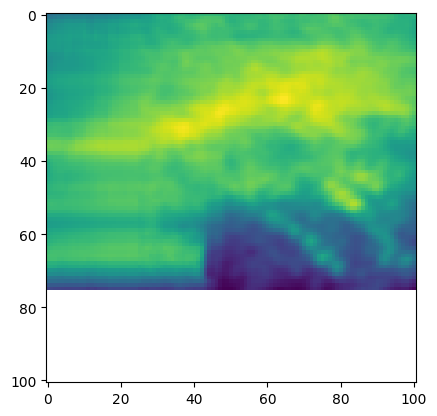

In [19]:
plt.imshow(C)

In [40]:
def xcorr2_nans(frame, template, shiftsCenter, dShift):
    """
    Perform a somewhat-efficient local normalized cross-correlation for images with NaNs.
    
    Parameters:
    - frame: the frame to be aligned; this has more NaNs
    - template: the template
    - shiftsCenter: the center offset around which to perform a local search
    - dShift: the maximum shift (scalar, in pixels) to consider on each axis around shiftsCenter
    
    Returns:
    - motion: the calculated motion vector
    - R: the correlation coefficient
    """
    
    # Create a kernel for dilation using OpenCV
    kernel_size = (2 * dShift + 1, 2 * dShift + 1)
    SE = np.ones(kernel_size, dtype=np.uint8)
    
    # Measure the time for the dilation operation
    start_dilation = time.time()
    
    # Use cv2.dilate to handle dilation operation
    template_nan_mask = np.isnan(template).astype(np.uint8)
    dilated_template_nan_mask = cv2.dilate(template_nan_mask, SE)
    
    # Shift the dilated mask and create valid mask for frame
    fValid = ~np.isnan(frame) & shift(~dilated_template_nan_mask.astype(bool), shiftsCenter)
    
    end_dilation = time.time()
    dilation_time = end_dilation - start_dilation
    print(f"Dilation took {dilation_time:.6f} seconds")
    
    fValid[:dShift, :] = False
    fValid[-dShift:, :] = False
    fValid[:, :dShift] = False
    fValid[:, -dShift:] = False

    tValid = np.roll(fValid, shift=-np.array(shiftsCenter))

    F = frame[fValid]  # fixed data
    ssF = np.sqrt(np.sum(F**2))

    shifts = np.arange(-dShift, dShift + 1)
    C = np.full((len(shifts), len(shifts)), np.nan)
    
    # Measure time for the for loop
    start_loop = time.time()
    
    for drix, dcix in np.ndindex(len(shifts), len(shifts)):
        T = template[np.roll(tValid, (-shifts[drix], shifts[dcix]), axis=(0, 1))]
        ssT = np.sum(T**2)
        C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)
        
    end_loop = time.time()
    loop_time = end_loop - start_loop
    print(f"For loop took {loop_time:.6f} seconds")

    maxval = np.nanmax(C)
    
    if np.isnan(maxval):
        raise ValueError("All-NaN slice encountered in cross-correlation.")
    
    rr, cc = np.unravel_index(np.nanargmax(C), C.shape)

    R = maxval / ssF  # correlation coefficient

    if 1 < rr < len(shifts) - 1 and 1 < cc < len(shifts) - 1:
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2

        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2

        motion = shiftsCenter + np.array([shifts[rr] - dR, shifts[cc] - dC])
    else:
        motion = shiftsCenter + np.array([shifts[rr], shifts[cc]])

    if np.any(np.isnan(motion)):
        raise ValueError("NaN encountered in motion calculation.")
        
    return motion, R

In [41]:
motion, R = xcorr2_nans(frame, template, shiftsCenter, dShift)

Dilation took 0.003965 seconds


/tmp/ipykernel_2846/2468854374.py:53: RuntimeWarning: invalid value encountered in scalar divide
  C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)


For loop took 0.592841 seconds


In [42]:
motion, R

(array([17.29284326, -6.42740901]), 0.29699048819933666)

In [15]:
import cv2
import numpy as np

def xcorr2_nans(frame, template, shiftsCenter, dShift):
    dShift = round(dShift)  # Sanity check

    # Create a structuring element for erosion
    SE = cv2.getStructuringElement(cv2.MORPH_RECT, (2 * dShift + 1, 2 * dShift + 1))

    # Valid pixels of the new frame
    fValid = ~np.isnan(frame) & np.roll(~cv2.dilate(np.isnan(template).astype(np.uint8), SE), shiftsCenter, axis=(0, 1))
    fValid[:dShift, :] = False
    fValid[-dShift:, :] = False
    fValid[:, :dShift] = False
    fValid[:, -dShift:] = False

    tValid = np.roll(fValid, -np.array(shiftsCenter), axis=(0, 1))  # Convert shiftsCenter to np.array

    # Fixed data
    F = frame[fValid]  
    ssF = np.sqrt(np.sum(F ** 2))

    # Correlation map
    shifts = np.arange(-dShift, dShift + 1)
    C = np.empty((len(shifts), len(shifts)))
    for drix in range(len(shifts)):
        for dcix in range(len(shifts)):
            T = template[np.roll(tValid, -np.array([shifts[drix], shifts[dcix]]), axis=(0, 1))]  # Convert shifts to np.array
            ssT = np.sum(T ** 2)
            C[drix, dcix] = np.nansum(F * T) / np.sqrt(ssT) if ssT != 0 else 0

    # Find maximum of correlation map
    maxval = np.nanmax(C)
    I = np.unravel_index(np.nanargmax(C), C.shape)
    rr, cc = I
    R = maxval / ssF  # Correlation coefficient

    if 0 < rr < len(shifts) - 1 and 0 < cc < len(shifts) - 1:
        # Perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        motion = shiftsCenter + [shifts[rr] - dR, shifts[cc] - dC]
    else:
        # The optimum is at an edge of search range; no superresolution
        motion = shiftsCenter + [shifts[rr], shifts[cc]]

    if np.any(np.isnan(motion)):
        raise ValueError('Motion result contains NaN values')

    return motion, R

motion, R = xcorr2_nans(frame, template, shiftsCenter, dShift)
motion, R

(array([-26, -70]), nan)

In [17]:
def downsampleTime(Y, ds_time):
    for _ in range(ds_time):
        Y = Y[:, :, :, :2*(Y.shape[3]//2):2] + Y[:, :, :, 1:2*(Y.shape[3]//2):2]
    return Y
    
for DSframe in range(0, nDSframes):
    # readFrames = slice((DSframe) * dsFac, DSframe * dsFac)
    readFrames = list(range((DSframe) * dsFac, (DSframe) * dsFac + dsFac))
    
    M = downsampleTime(Ad[:, :, :, readFrames], ds_time)
    M = np.squeeze(np.sum(M[:, :, selCh, :].reshape(M.shape[0], M.shape[1], -1, M.shape[3]), axis=2))
    # M = np.sum(M, axis=2)  # Merge frames
    # M = np.transpose(M)
    # M = M - convolve2d(M, np.ones((4, 4))/16, mode='same')  # Highpass filter using Gaussian approximation

    if DSframe % 1000 == 0:
        print(f'{DSframe} of {nDSframes}')

    Ttmp = np.nanmean(np.dstack((T0, T00, template)), axis=2)
    
    T = Ttmp[(maxshift - initR):(maxshift - initR + sz[0]), (maxshift - initC):(maxshift - initC + sz[1])]
    
    output,_ = dftregistration_clipped(fft2(M), fft2(T.astype(np.float32)), 4, clipShift)
    # output = phase_cross_correlation(fft2(T.astype(np.float32)), fft2(M), normalization = 'phase', overlap_ratio = 1-maxshift/min(sz[0:2]), upsample_factor = 400) # Check normization = None vs phase and check output of shifts. 

    motionDSr[DSframe] = initR + output[2]
    motionDSc[DSframe] = initC + output[3]
    aErrorDS[DSframe] = output[0]

    # Check the condition
    if np.sqrt((motionDSr[DSframe] / sz[0])**2 + (motionDSc[DSframe] / sz[1])**2) > 0.75**2:
        # Create a meshgrid for the coordinates
        x = np.arange(sz[1])
        y = np.arange(sz[0])
        mesh_x, mesh_y = np.meshgrid(x, y)
        
        # Use cv2.remap for interpolation
        map_x = np.float32(viewC)
        map_y = np.float32(viewR)
        Mfull = cv2.remap(M.astype(np.float32), map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)
        
        motion, R = xcorr2_nans(Mfull, Ttmp, np.array([initR, initC]), 50)
        
        # Update the motion and error arrays
        motionDSr[DSframe] = motion[0]
        motionDSc[DSframe] = motion[1]
        aErrorDS[DSframe] = R

    if abs(motionDSr[DSframe]) < maxshift and abs(motionDSc[DSframe]) < maxshift:
        # Create grid points
        X, Y = np.meshgrid(np.arange(0, sz[1]), np.arange(0, sz[0]))

        # Calculate new grid points
        Xq = viewC + motionDSc[DSframe]  # Adjust index for Python's 0-based indexing
        Yq = viewR + motionDSr[DSframe]  # Adjust index for Python's 0-based indexing

        # Perform interpolation using cv2.remap over scipy.interpolate.griddata
        A = cv2.remap(M, Xq.astype(np.float32), Yq.astype(np.float32), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)

        Asmooth = cv2.GaussianBlur(A, (0, 0), sigmaX=1)

        selCorr = ~(np.isnan(Asmooth) | np.isnan(Ttmp))
        aRankCorr[DSframe] = np.corrcoef(Asmooth[selCorr], Ttmp[selCorr])[0, 1]  # Use Spearman correlation
        recNegErr[DSframe] = np.mean(np.power(np.minimum(0, Asmooth[selCorr] * np.mean(Ttmp[selCorr]) / np.mean(Asmooth[selCorr]) - Ttmp[selCorr]), 2))

        templateCt = np.isnan(template).astype(int)
        template = np.where(np.isnan(template), 0, template)
        template = np.where(np.isnan(A), template, template * templateCt + A)
        templateCt = templateCt + (~np.isnan(A)).astype(int)
        template = template / templateCt
        template[templateCt < 100] = np.nan

        initR = round(motionDSr[DSframe])
        initC = round(motionDSc[DSframe])
    else:
        motionDSr[DSframe] = initR
        motionDSc[DSframe] = initC

0 of 1125


NameError: name 'T0' is not defined

In [9]:
import tifffile
import numpy as np

def read_tiff_file(fn):
    print('Reading:', fn)
    # A = ScanImageTiffReader(fn)
    # Ad = np.array(A.data(), dtype=np.float32)
    # return Ad
    with tifffile.TiffFile(fn) as tif:
        imageData = tif.asarray()
        Ad = np.array(imageData, dtype=np.float32)
        print('Shape while reading tiff---->', Ad.shape)
        numChannels = Ad.shape[1]
    return Ad, numChannels  

In [10]:
fn = '/root/capsule/scratch/iGluSnfr-Michael/1/scan_00002_20240720_161305.tif'

try:
    Ad, numChannels = read_tiff_file(fn)
    Ad = np.transpose(Ad, (2, 3, 1, 0))
except Exception as e:
    print(f"Failed to read {fn} after multiple attempts: {e}")

Reading: /root/capsule/scratch/iGluSnfr-Michael/1/scan_00002_20240720_161305.tif
Shape while reading tiff----> (168551, 2, 50, 128)


In [11]:
Ad = Ad[:,:,:,:3000]

In [12]:
Ad.shape

(50, 128, 2, 3000)

# Incorporate Michaels updates

In [1]:
import os
import cv2
import csv
import argparse
import re
import pytz
import json
import glob
import h5py
import dateparser
from datetime import datetime
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
from scipy.fft import fft2
import numpy.ma as ma
from scipy.interpolate import interp1d
from scipy.interpolate import interp1d, PchipInterpolator
from utils.stripRegistrationBergamo import stripRegistrationBergamo_init
from utils.suite2pRegistration import suite2pRegistration
from utils.CaImAnRegistration import CaImAnRegistration
from aind_data_schema.core.data_description import Funding, RawDataDescription
from aind_data_schema_models.modalities import Modality
from aind_data_schema_models.organizations import Organization
from aind_data_schema_models.pid_names import PIDName
from aind_data_schema_models.platforms import Platform
import logging
from tenacity import retry, stop_after_attempt, wait_fixed
import warnings
import tifffile
warnings.filterwarnings("ignore")

In [2]:
tif_files = []
for root, dirs, files in os.walk('/root/capsule/scratch/iGluSnfr-Michael/'):
    for file in files:
        if file.endswith('.tif'):
            file_path = os.path.join(root, file)
            folder_number = os.path.basename(os.path.dirname(file_path))
            tif_files.append((file_path, folder_number))

tif_files

[('/root/capsule/scratch/iGluSnfr-Michael/1/scan_00002_20240720_161305.tif',
  '1')]

In [11]:
# @retry(stop=stop_after_attempt(4), wait=wait_fixed(300))
def read_tiff_file(fn):
    print('Reading:', fn)
    A = ScanImageTiffReader(fn)
    Ad = np.array(A.data(), dtype=np.float32)
    return Ad

# @retry(stop=stop_after_attempt(4), wait=wait_fixed(200))
# def read_tiff_file(fn):
#     print('Reading:', fn)
#     with tifffile.TiffFile(fn) as tif:
#         imageData = tif.asarray()
#         Ad = np.array(imageData, dtype=np.float32)
#         numChannels = Ad.shape[1]
#     return Ad, numChannels  

In [12]:
fn = '/root/capsule/scratch/iGluSnfr-Michael/1/scan_00002_20240720_161305.tif'

try:
    Ad, numChannels = read_tiff_file(fn)
    Ad = np.reshape(Ad, (Ad.shape[0], Ad.shape[1], numChannels, -1))
except Exception as e:
    print(f"Failed to read {fn} after multiple attempts: {e}")


Reading: /root/capsule/scratch/iGluSnfr-Michael/1/scan_00002_20240720_161305.tif
Failed to read /root/capsule/scratch/iGluSnfr-Michael/1/scan_00002_20240720_161305.tif after multiple attempts: Resource temporarily unavailable


In [10]:
Ad.shape

(168551, 2, 2, 3200)

In [8]:
Ad.shape

(168551, 2, 50, 128)

In [ ]:
Ad.shape

# 1. Strip Registeration

In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from skimage.registration import phase_cross_correlation
from tifffile import imread, imwrite
import os
from os import path, makedirs
from os.path import exists
import h5py
from ScanImageTiffReader import ScanImageTiffReader
from datetime import datetime
import dateparser
import shutil
import numpy as np
from jnormcorre.motion_correction import frame_corrector, MotionCorrect
import re

from scipy.ndimage import map_coordinates
from scipy.fft import fft2
import scipy
from scipy.interpolate import interp2d
from scipy.signal import convolve2d
import numpy.ma as ma
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d, pchip_interpolate, PchipInterpolator
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
import cv2
from tifffile import tifffile

In [2]:
def downsampleTime(Y, ds_time):
    for _ in range(ds_time):
        Y = Y[:, :, :, :2*(Y.shape[3]//2):2] + Y[:, :, :, 1:2*(Y.shape[3]//2):2]
    return Y

def evaluate_description(desc):
    # Split the data into lines
    lines = desc.strip().split('\n')

    # Parse each line
    parsed_data = {}
    for line in lines:
        # Split the line into key and value
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        
        # Try to evaluate the value as Python literal if possible
        try:
            value = eval(value)
        except (NameError, SyntaxError):
            # If eval fails, keep the value as a string
            pass
        
        # Store in the dictionary
        parsed_data[key] = value

    # Print the parsed data
    # for key, value in parsed_data.items():
    #     print(f"{key}: {value}")

    return parsed_data

In [6]:
# data_dir = '/Users/caleb.shibu/Desktop/code/SLAP2-Caleb/SIMULATIONS/Standard2'
data_dir = '/data/iGluSnFR-testing-Sim-Data/SIMULATIONS/Standard2/'

fns = [fn for fn in os.listdir(data_dir) if fn.endswith('.tif')]

patter_raw_tiff = r'^scan_00003_\d{8}_\d{6}\.tif$' # This pattern might change. 

ds_time = None

maxshift = 30
clipShift = 5  # the maximum allowable shift per frame
alpha = 0.0005  # exponential time constant for template
removeLines = 4

if ds_time is None:
    ds_time = 3  # the movie is downsampled using averaging in time by a factor of 2^ds_time
dsFac = 2 ** ds_time

for fn in fns:
    fns_string = ', '.join(str(element) for element in fns)
    if re.match(patter_raw_tiff, fn):
        print('Gathering metadata from raw tiff file:', fn)
        A_raw = ScanImageTiffReader(os.path.join(data_dir, fn))
        desc = A_raw.description(1)

        # Evaluate the description
        parsed_data = evaluate_description(desc)

        # Get epoch time from the description
        epoch_time = parsed_data['epoch']

        # Remove brackets and split by spaces
        parts = epoch_time.strip('[]').split()

        # Reformat to a more standard date-time string (e.g., "YYYY-MM-DD HH:MM:SS.sss")
        formatted_time = f"{parts[0]}-{parts[1]}-{parts[2]} {parts[3]}:{parts[4]}:{parts[5]}"

        # Parse the formatted string
        parsed_date = dateparser.parse(formatted_time)

        dateAcqAsString = parsed_date.strftime('%Y%m%d_%H%M%S')

        # Extract the directory path and filename from the original file path
        dir_path, filename = os.path.split(fns_string)

        # Define the new directory path by appending 'registration' to the original directory path
        registration_dir = os.path.join(data_dir, 'registration')

        # Create the 'registration' directory if it doesn't already exist
        os.makedirs(registration_dir, exist_ok=True)

        # Define the destination file path within the new 'registration' directory
        # destination_file_path = os.path.join(registration_dir, filename)

        # Copy the original file to the new location
        # shutil.copy(fns_string, destination_file_path)

        # print(f"File copied to: {destination_file_path}")

        meta = A_raw.metadata()
        meta_lines = meta.split('\n')

        for line in meta_lines:
            try:
                exec(line)
            except Exception:
                pass
            
        # Initialize numChannels to None or 0 as a default value
        numChannels = None

        # Iterate through each line in meta_lines
        for line in meta_lines:
            # Check if the line contains the assignment to SI.hChannels.channelSave
            if "SI.hChannels.channelSave" in line:
                # Extract the part of the line after the '=' sign
                right_hand_side = line.split('=')[1].strip()
                
                # Evaluate the right-hand side to get the list (remove the semicolon if present)
                channel_list = eval(right_hand_side.rstrip(';'))
                
                # Calculate the length of the list and assign it to numChannels
                numChannels = channel_list

                break  # Exit the loop if the assignment is found

        # Print numChannels to verify
        print("Number of Channels:", numChannels)

        # Pattern to match the timestamps in the description
        pattern = r"frameTimestamps_sec = (\d+)\.(\d+)"

        # numChannels = 1  # Adjust this based on your actual number of channels
        timestamp = []

        # Extract timestamps from the descriptions
        for frame in range(10 * numChannels):
            des = A.description(frame)
            lines = des.strip().split('\n')

            for line in lines:
                match = re.search(pattern, line)
                if match:
                    # Convert the matched timestamp to float and append to the list
                    timestamp.append(float(match.group(1) + '.' + match.group(2)))
            # match = re.search(pattern, desc[frame])
            # if match:
            #     # Convert the matched timestamp to float and append to the list
            #     timestamp.append(float(match.group(1) + '.' + match.group(2)))

        # Calculate the time difference between frames and find the median frametime
        frametime = np.median(np.diff(timestamp[0::numChannels]))   

    if not re.match(patter_raw_tiff, fn):
        numChannels = 1
        print('Reading simulated tif', fn)
        A = ScanImageTiffReader(os.path.join(data_dir, fn))
        Ad = np.array(A.data(), dtype=np.float32)

        print("Original data shape:", Ad.shape)

        # Reshape the array while preserving the number of rows and columns, and considering the number of channels
        # The '-1' in reshape will automatically calculate the size of the last dimension
        Ad = np.reshape(Ad, (Ad.shape[0], Ad.shape[1], numChannels, -1))

        # Permute the dimensions of the array to reorder them
        Ad = np.transpose(Ad, (1, 3, 2, 0))
        # Ad = np.transpose(Ad, (3, 2, 1, 0))

        # Remove the specified lines from the array
        Ad = Ad[removeLines:, :, :, :]

        print("Data shape after reshaping and transposing:", Ad.shape)

        initFrames = 400
        framesToRead = initFrames * dsFac

        # Downsample the data
        Y = downsampleTime(Ad[:, :, :, :framesToRead], ds_time)

        #Get size of the original data
        sz = Ad.shape

        # Sum along the third dimension and squeeze the array
        Yhp = np.squeeze(np.sum(Y,2))
        
        break # For the sake of debugging, break after the first file is processed

Reading simulated tif SIMULATION_scan_00003_Standard2_Trial3.tif
Original data shape: (10000, 125, 45)
Data shape after reshaping and transposing: (121, 45, 1, 10000)


In [7]:

corrector = MotionCorrect(lazy_dataset=Yhp.transpose(2, 1, 0),
                            max_shifts=(maxshift, maxshift),  # Maximum allowed shifts in pixels
                            strides=(48, 48),  # Patch dimensions for piecewise rigid correction
                            overlaps=(24, 24),  # Overlap between patches
                            max_deviation_rigid=3,  # Maximum deviation for rigid correction
                            pw_rigid = False)  # Number of frames to process in a batch

# corrected_frames = np.zeros_like(Yhp)
# for i in range(Yhp.shape[2]):
#     frame = Yhp[:, :, i]
#     corrected_frame = corrector.register_frames(frame)

#     corrected_frames[:, :, i] = corrected_frame

frame_corrector, output_file = corrector.motion_correct(
    template=None, save_movie=True
)

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


In [8]:
template = ScanImageTiffReader(os.path.join('/code/',''.join(output_file))) # After Normcorre 
F = template.data()
F = np.transpose(F, (2, 1, 0))
F = np.mean(F, axis=2)

# # Create a template with NaNs
template = np.full((2*maxshift + sz[0], 2*maxshift + sz[1]), np.nan)

# # Insert the matrix F into the template
template[maxshift:maxshift+sz[0], maxshift:maxshift+sz[1]] = F

# template = np.transpose(template)

# # Copy the template to T0
T0 = template.copy()

# Create T00 as a zero matrix of the same size as template
T00 = np.zeros_like(template)

In [9]:
initR = 0
initC = 0

# Calculate the number of downsampled frames
nDSframes = np.floor(sz[3] / dsFac).astype(int)  # Using sz[3] as it corresponds to MATLAB's sz(4)

# Initialize arrays to store the inferred motion and errors
motionDSr = np.nan * np.ones(nDSframes)
motionDSc = np.nan * np.ones(nDSframes)
aErrorDS = np.nan * np.ones(nDSframes)
aRankCorr = np.nan * np.ones(nDSframes)
recNegErr = np.nan * np.ones(nDSframes)

# Create view matrices for interpolation
viewR, viewC = np.meshgrid(
    np.arange(0, sz[0] + 2 * maxshift) - maxshift, #sz in matlab is 121, 45, 1, 10000
    np.arange(0, sz[1] + 2 * maxshift) - maxshift,
    indexing='ij'  # 'ij' for matrix indexing to match MATLAB's ndgrid
)

In [10]:
def dftregistration_clipped(buf1ft, buf2ft, usfac=1, clip=None):
    if clip is None:
        clip = [0, 0]
    elif isinstance(clip, (int, float)):
        clip = [clip, clip]

    # Compute error for no pixel shift
    if usfac == 0:
        CCmax = np.sum(buf1ft * np.conj(buf2ft))
        rfzero = np.sum(np.abs(buf1ft.flatten()) ** 2)
        rgzero = np.sum(np.abs(buf2ft.flatten()) ** 2)
        error = 1.0 - CCmax * np.conj(CCmax) / (rgzero * rfzero)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))
        output = [error, diffphase]
        return output, None

    # Whole-pixel shift - Compute crosscorrelation by an IFFT and locate the peak
    elif usfac == 1:
        m, n = buf1ft.shape
        md2 = m // 2
        nd2 = n // 2
        CC = np.fft.ifft2(buf1ft * np.conj(buf2ft))

        keep = np.ones(CC.shape, dtype=bool)
        keep[clip[0] // 2 + 1 : -clip[0] // 2, :] = False
        keep[:, clip[1] // 2 + 1 : -clip[1] // 2] = False
        CC[~keep] = 0

        max1 = np.max(np.real(CC), axis=1)
        loc1 = np.argmax(np.real(CC), axis=1)
        max2 = np.max(max1)
        loc2 = np.argmax(max1)
        rloc = loc1[loc2]
        cloc = loc2
        CCmax = CC[rloc, cloc]
        rfzero = np.sum(np.abs(buf1ft.flatten()) ** 2) / (m * n)
        rgzero = np.sum(np.abs(buf2ft.flatten()) ** 2) / (m * n)
        error = 1.0 - CCmax * np.conj(CCmax) / (rgzero * rfzero)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))

        md2 = m // 2
        nd2 = n // 2
        if rloc > md2:
            row_shift = rloc - m
        else:
            row_shift = rloc

        if cloc > nd2:
            col_shift = cloc - n
        else:
            col_shift = cloc

        output = [error, diffphase, row_shift, col_shift]
        return output, None

    # Partial-pixel shift
    else:
        # First upsample by a factor of 2 to obtain initial estimate
        # Embed Fourier data in a 2x larger array
        m, n = buf1ft.shape
        mlarge = m * 2
        nlarge = n * 2
        CC = np.zeros((mlarge, nlarge), dtype=np.complex128)
        CC[
            m - (m // 2) : m + (m // 2) + 1,
            n - (n // 2) : n + (n // 2) + 1,
        ] = np.fft.fftshift(buf1ft) * np.conj(np.fft.fftshift(buf2ft))

        # Compute crosscorrelation and locate the peak
        CC = np.fft.ifft2(np.fft.ifftshift(CC))  # Calculate cross-correlation

        keep = np.ones(CC.shape, dtype=bool)
        keep[2 * clip[0] + 1 : -2 * clip[0], :] = False
        keep[:, 2 * clip[1] + 1 : -2 * clip[1]] = False
        CC[~keep] = 0

        max1 = np.max(np.real(CC), axis=1)
        loc1 = np.argmax(np.real(CC), axis=1)
        max2 = np.max(max1)
        loc2 = np.argmax(max1)
        max_val = np.max(np.real(CC))
        rloc, cloc = np.unravel_index(np.argmax(np.real(CC)), CC.shape)
        CCmax = CC[rloc, cloc]

        # Obtain shift in original pixel grid from the position of the
        # crosscorrelation peak
        m, n = CC.shape
        md2 = m // 2
        nd2 = n // 2
        if rloc > md2:
            row_shift = rloc - m
        else:
            row_shift = rloc
        if cloc > nd2:
            col_shift = cloc - n
        else:
            col_shift = cloc
        row_shift = row_shift / 2
        col_shift = col_shift / 2

        # If upsampling > 2, then refine estimate with matrix multiply DFT
        if usfac > 2:
            # Initial shift estimate in upsampled grid
            row_shift = round(row_shift * usfac) / usfac
            col_shift = round(col_shift * usfac) / usfac
            dftshift = np.fix(np.ceil(usfac * 1.5) / 2)  # Center of output array at dftshift+1
            # Matrix multiply DFT around the current shift estimate
            CC = np.conj(
                dftups(
                    buf2ft * np.conj(buf1ft),
                    np.ceil(usfac * 1.5),
                    np.ceil(usfac * 1.5),
                    usfac,
                    dftshift - row_shift * usfac,
                    dftshift - col_shift * usfac,
                )
            ) / (md2 * nd2 * usfac ** 2)
            # Locate maximum and map back to original pixel grid
            max1 = np.max(np.real(CC), axis=1)
            loc1 = np.argmax(np.real(CC), axis=1)
            max2 = np.max(max1)
            loc2 = np.argmax(max1)
            rloc = loc1[loc2]
            cloc = loc2
            CCmax = CC[rloc, cloc]
            rg00 = dftups(buf1ft * np.conj(buf1ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
            rf00 = dftups(buf2ft * np.conj(buf2ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
            rloc = rloc - dftshift
            cloc = cloc - dftshift
            row_shift = row_shift + rloc / usfac
            col_shift = col_shift + cloc / usfac

        # If upsampling = 2, no additional pixel shift refinement
        else:
            rg00 = np.sum(buf1ft * np.conj(buf1ft)) / m / n
            rf00 = np.sum(buf2ft * np.conj(buf2ft)) / m / n
        error = 1.0 - CCmax * np.conj(CCmax) / (rg00 * rf00)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))
        # If its only one row or column the shift along that dimension has no
        # effect. We set to zero.
        if md2 == 1:
            row_shift = 0
        if nd2 == 1:
            col_shift = 0
        output = [error, diffphase, row_shift, col_shift]

    # Compute registered version of buf2ft
    if usfac > 0:
        nr, nc = buf2ft.shape
        Nr = np.fft.ifftshift(np.arange(-np.fix(nr / 2), np.ceil(nr / 2)))
        Nc = np.fft.ifftshift(np.arange(-np.fix(nc / 2), np.ceil(nc / 2)))
        Nc, Nr = np.meshgrid(Nc, Nr)
        Greg = buf2ft * np.exp(
            1j * 2 * np.pi * (-row_shift * Nr / nr - col_shift * Nc / nc)
        )
        Greg = Greg * np.exp(1j * diffphase)
    elif usfac == 0:
        Greg = buf2ft * np.exp(1j * diffphase)
    else:
        Greg = None

    return output, Greg


def dftups(inp, nor, noc, usfac, roff=0, coff=0):
    nr, nc = inp.shape
    # Compute kernels and obtain DFT by matrix products
    kernc = np.exp(
        (-1j * 2 * np.pi / (nc * usfac))
        * (np.fft.ifftshift(np.arange(nc)).reshape(-1, 1) - np.floor(nc / 2))
        * (np.arange(noc) - coff)
    )
    kernr = np.exp(
        (-1j * 2 * np.pi / (nr * usfac))
        * (np.arange(nor).reshape(-1, 1) - roff)
        * (np.fft.ifftshift(np.arange(nr)) - np.floor(nr / 2))
    )
    out = np.dot(np.dot(kernr, inp), kernc)
    return out

In [11]:
print('Registering...')

for DSframe in range(0, nDSframes):
    # readFrames = slice((DSframe) * dsFac, DSframe * dsFac)
    readFrames = list(range((DSframe) * dsFac, (DSframe) * dsFac + dsFac))
    
    M = downsampleTime(Ad[:, :, :, readFrames], ds_time)
    M = np.squeeze(np.sum(M, axis=2))
    # M = np.sum(M, axis=2)  # Merge frames
    # M = np.transpose(M)
    # M = M - convolve2d(M, np.ones((4, 4))/16, mode='same')  # Highpass filter using Gaussian approximation

    if DSframe % 1000 == 0:
        print(f'{DSframe} of {nDSframes}')

    Ttmp = np.nanmean(np.dstack((T0, T00, template)), axis=2)
    
    T = Ttmp[maxshift - initR:maxshift - initR + sz[0], maxshift - initC:maxshift - initC + sz[1]]
    
    output,_ = dftregistration_clipped(fft2(M), fft2(T.astype(np.float32)), 4, clipShift)
    # output = phase_cross_correlation(fft2(T.astype(np.float32)), fft2(M), normalization = 'phase', overlap_ratio = 1-maxshift/min(sz[0:2]), upsample_factor = 400) # Check normization = None vs phase and check output of shifts. 
        
    # print('shifts:', output [0], output[0])

    # print('init:', initR, initC)

    motionDSr[DSframe] = initR + output[2]
    motionDSc[DSframe] = initC + output[3]
    aErrorDS[DSframe] = output[0]

    if abs(motionDSr[DSframe]) < maxshift and abs(motionDSc[DSframe]) < maxshift:
        # interpolator = interp2d(np.arange(sz[1]), np.arange(sz[0]), M, kind='linear', bounds_error=False, fill_value=np.nan)
        # A = interpolator(viewC + motionDSc[DSframe - 1], viewR + motionDSr[DSframe - 1])

        # Create grid points
        X, Y = np.meshgrid(np.arange(0, sz[1]), np.arange(0, sz[0]))

        # Calculate new grid points
        Xq = viewC + motionDSc[DSframe]  # Adjust index for Python's 0-based indexing
        Yq = viewR + motionDSr[DSframe]  # Adjust index for Python's 0-based indexing

        # Perform interpolation using griddata
        # A = scipy.interpolate.griddata((X.flatten(), Y.flatten()), M.flatten(), (Xq, Yq), method='linear', fill_value=np.nan)

        A = cv2.remap(M, Xq.astype(np.float32), Yq.astype(np.float32), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)
        
        sel = ~np.isnan(A)
        selCorr = ~np.isnan(A) & ~np.isnan(template)
        A_ma = ma.array(A, mask=~selCorr)
        template_ma = ma.array(template, mask=~selCorr)

        aRankCorr[DSframe] = ma.corrcoef(ma.array([A_ma.compressed(), template_ma.compressed()]))[0, 1]
        recNegErr[DSframe] = ma.mean(np.power(ma.minimum(0, A_ma - template_ma), 2))

        nantmp = sel & np.isnan(template)
        template[nantmp] = A[nantmp]
        template[sel] = (1 - alpha) * template[sel] + alpha * A[sel]

        initR = round(motionDSr[DSframe])
        initC = round(motionDSc[DSframe])

Registering...
0 of 1250


/tmp/ipykernel_96/2972060396.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aErrorDS[DSframe] = output[0]


1000 of 1250


In [13]:
# Upsample the shifts and compute a tighter field of view
tDS = np.multiply(np.arange(1, nDSframes+1), dsFac) - 2**(ds_time-1) + 0.5

# interp_func = interp1d(tDS, motionDSc, kind='linear', fill_value='extrapolate', copy = False)
# motionC = interp_func(np.arange(0, 2**ds_time * nDSframes))
# interp_func = interp1d(tDS, motionDSr, kind='linear', fill_value='extrapolate', copy = False)
# motionR = interp_func(np.arange(0, 2**ds_time * nDSframes))

# interp_func = interp1d(tDS, aErrorDS, kind='nearest', fill_value='extrapolate', copy = False)
# aError = interp_func(np.arange(0, 2**ds_time * nDSframes))
# Create the new time points
new_time_points = np.arange(0, (2**ds_time) * nDSframes)

# Pchip Interpolator for motionC and motionR with extrapolation
pchip_interpolator_c = PchipInterpolator(tDS, motionDSc, extrapolate=True)
pchip_interpolator_r = PchipInterpolator(tDS, motionDSr, extrapolate=True)
motionC = pchip_interpolator_c(new_time_points)
motionR = pchip_interpolator_r(new_time_points)

# Nearest neighbor interpolation for aError with extrapolation
nearest_interpolator = interp1d(tDS, aErrorDS, kind='nearest', fill_value='extrapolate')
aError = nearest_interpolator(new_time_points)

maxshiftC = np.max(np.abs(motionC))
maxshiftR = np.max(np.abs(motionR))

viewR, viewC = np.meshgrid(
    np.arange(0, sz[0] + 2 * maxshiftR) - maxshiftR,
    np.arange(0, sz[1] + 2 * maxshiftC) - maxshiftC,
    indexing='ij'  # This makes meshgrid behave like MATLAB's ndgrid
)

pixelscale = 4e4  # PIXEL SIZE IN DOTS PER CM

In [15]:
import h5py
import numpy as np

# Open the HDF5 file
with h5py.File('/data/iGluSnFR-testing-Sim-Data/SIMULATIONS/Standard2/SIMULATION_scan_00003_Standard2_Trial3_groundtruth.h5', 'r') as file:
    # Read the datasets
    gt_motionC = file['GT/motionC'][:]
    adata_motionC = file['aData/motionC'][:]

    gt_motionR = file['GT/motionR'][:]
    adata_motionR = file['aData/motionR'][:]

    # Ensure the datasets have the same shape
    if gt_motionC.shape != adata_motionC.shape:
        raise ValueError("Datasets have different shapes and cannot be compared.")
    if gt_motionR.shape != adata_motionR.shape:
        raise ValueError("Datasets have different shapes and cannot be compared.")

    # Compute the mean of each signal
    mean_gt_motionC = np.mean(gt_motionC)
    mean_motionC = np.mean(motionC)
    mean_gt_motionR = np.mean(gt_motionR)
    mean_motionR = np.mean(motionR)

    # Center the signals by subtracting the mean
    centered_gt_motionC = gt_motionC - mean_gt_motionC
    centered_motionC = adata_motionC - mean_motionC
    centered_gt_motionR = gt_motionR - mean_gt_motionR
    centered_motionR = adata_motionR - mean_motionR

    # Compute the Mean Squared Error (MSE)
    mse_c = np.mean(np.square(centered_gt_motionC - centered_motionC))
    mse_r = np.mean(np.square(centered_gt_motionR - centered_motionR))

    print(f"Mean Squared Error (MSE) between centered GT/motionC and aData/motionC: {mse_c}")
    print(f"Mean Squared Error (MSE) between centered GT/motionR and aData/motionR: {mse_r}")

Mean Squared Error (MSE) between centered GT/motionC and aData/motionC: 0.07378226048685069
Mean Squared Error (MSE) between centered GT/motionR and aData/motionR: 0.28259148921361965


# 2. Suite2p

In [1]:
import os
# os.environ['OMP_DISPLAY_ENV'] = 'True'
import matplotlib.pyplot as plt
import suite2p
import numpy as np
from tifffile import imread

fname = '/data/iGluSnFR-testing-Sim-Data/SIMULATIONS/Standard2/SIMULATION_scan_00003_Standard2_Trial3.tif'
data = imread(fname)
print('imaging data of shape: ', data.shape)
n_time, Ly, Lx = data.shape

imaging data of shape:  (10000, 125, 45)


In [2]:
ops = np.load("/scratch/ops.npy", allow_pickle = True).item()

# ops = suite2p.default_ops()

# only run on specified tiffs
db = {
      # 'h5py': [], # a single h5 file path
      # 'h5py_key': 'data',
      'reg_tif': True,
      'combined': True,
      'save_path0':'/scratch/',
      'look_one_level_down': False, # whether to look in ALL subfolders when searching for tiffs
      'data_path': ['/data/iGluSnFR-testing-Sim-Data/SIMULATIONS/Standard2'], 
                    # a list of folders with tiffs 
                    # (or folder of folders with tiffs if look_one_level_down is True, or subfolders is not empty)        
      'subfolders': [], # choose subfolders of 'data_path' to look in (optional)
    #   'fast_disk': 'C:/BIN', # string which specifies where the binary file will be stored (should be an SSD)
      'tiff_list': ['SIMULATION_scan_00003_Standard2_Trial3.tif'] # list of tiffs in folder * data_path *!
    }


# # run one experiment
opsEnd = suite2p.run_s2p(ops=ops, db=db)

# # Read in raw tif corresponding to our example tif
# f_raw = suite2p.io.BinaryFile(Ly=Ly, Lx=Lx, filename=fname)
# # Create a binary file we will write our registered image to 
# f_reg = suite2p.io.BinaryFile(Ly=Ly, Lx=Lx, filename='registered_data.bin', n_frames = f_raw.shape[0]) # Set registered binary file to have same n_frames

{'reg_tif': True, 'combined': True, 'save_path0': '/scratch/', 'look_one_level_down': False, 'data_path': ['/data/iGluSnFR-testing-Sim-Data/SIMULATIONS/Standard2'], 'subfolders': [], 'tiff_list': ['SIMULATION_scan_00003_Standard2_Trial3.tif']}
tif
** Found 1 tifs - converting to binary **
2000 frames of binary, time 0.79 sec.
4000 frames of binary, time 1.09 sec.
6000 frames of binary, time 1.30 sec.
8000 frames of binary, time 1.52 sec.
10000 frames of binary, time 1.73 sec.
time 2.48 sec. Wrote 10000 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: Applying builtin classifier at /src/suite2p/suite2p/classifiers/classifier.npy
----------- REGISTRATION
Reference frame, 6.83 sec.
Registered 500/10000 in 5.68s
Registered 1000/10000 in 11.38s
Registered 1500/10000 in 17.23s
Registered 2000/10000 in 23.35s
Registered 2500/10000 in 28.91s
Re

In [7]:
# Read in raw tif corresponding to our example tif
# f_raw = suite2p.io.BinaryFile(Ly=Ly, Lx=Lx, filename='/scratch/SIMULATION_scan_00003_Standard2_Trial3.tif')
# Create a binary file we will write our registered image to 
f_reg = suite2p.io.BinaryFile(Ly=Ly, Lx=Lx, filename= opsEnd['save_path'] + '/data.bin', n_frames = n_time).data

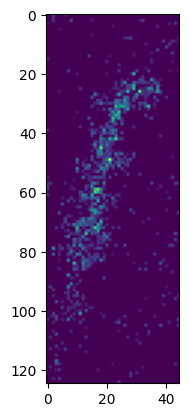

In [8]:
import matplotlib.pyplot as plt
f_reg[f_reg < 0] = 0
f_reg = np.uint16(f_reg)
plt.imshow(f_reg[1000, :, :])

In [14]:
refImg, rmin, rmax, meanImg, rigid_offsets, \
nonrigid_offsets, zest, meanImg_chan2, badframes, \
yrange, xrange = suite2p.registration_wrapper(f_reg, f_raw=f_raw, f_reg_chan2=None, 
                                                   f_raw_chan2=None, refImg=None, 
                                                   align_by_chan2=False, ops=ops)

Reference frame, 8.87 sec.
Registered 500/20158 in 0.77s
Registered 1000/20158 in 1.33s
Registered 1500/20158 in 2.19s
Registered 2000/20158 in 2.81s
Registered 2500/20158 in 3.43s
Registered 3000/20158 in 4.22s
Registered 3500/20158 in 4.87s
Registered 4000/20158 in 5.71s
Registered 4500/20158 in 6.47s
Registered 5000/20158 in 7.07s
Registered 5500/20158 in 7.83s
Registered 6000/20158 in 8.62s
Registered 6500/20158 in 9.45s
Registered 7000/20158 in 10.13s
Registered 7500/20158 in 12.30s
Registered 8000/20158 in 13.53s
Registered 8500/20158 in 15.51s
Registered 9000/20158 in 17.68s
Registered 9500/20158 in 20.97s
Registered 10000/20158 in 22.41s


ValueError: could not broadcast input array from shape (500,125,45) into shape (0,125,45)

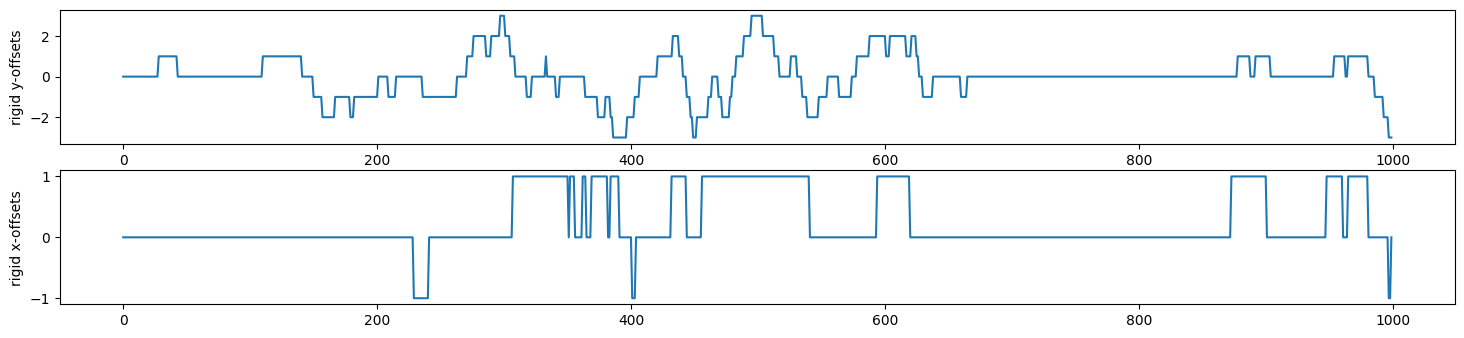

In [19]:
plt.figure(figsize=(18,8))

plt.subplot(4,1,1)
plt.plot(opsEnd['yoff'][:1000])
plt.ylabel('rigid y-offsets')

plt.subplot(4,1,2)
plt.plot(opsEnd['xoff'][:1000])
plt.ylabel('rigid x-offsets')

# plt.subplot(4,1,3)
# plt.plot(opsEnd['yoff1'][:1000])
# plt.ylabel('nonrigid y-offsets')

# plt.subplot(4,1,4)
# plt.plot(opsEnd['xoff1'][:1000])
# plt.ylabel('nonrigid x-offsets')
# plt.xlabel('frames')

plt.show()

In [20]:
import h5py
import numpy as np

# Open the HDF5 file
with h5py.File('/data/iGluSnFR-testing-Sim-Data/SIMULATIONS/Standard2/SIMULATION_scan_00003_Standard2_Trial3_groundtruth.h5', 'r') as file:
    # Read the datasets
    gt_motionC = file['GT/motionC'][:]
    adata_motionC = opsEnd['yoff']

    gt_motionR = file['GT/motionR'][:]
    adata_motionR = opsEnd['xoff']

    # Ensure the datasets have the same shape
    if gt_motionC.shape != adata_motionC.shape:
        raise ValueError("Datasets have different shapes and cannot be compared.")
    if gt_motionR.shape != adata_motionR.shape:
        raise ValueError("Datasets have different shapes and cannot be compared.")

    # Compute the mean of each signal
    mean_gt_motionC = np.mean(gt_motionC)
    mean_motionC = np.mean(opsEnd['yoff'])
    mean_gt_motionR = np.mean(gt_motionR)
    mean_motionR = np.mean(opsEnd['xoff'])

    # Center the signals by subtracting the mean
    centered_gt_motionC = gt_motionC - mean_gt_motionC
    centered_motionC = adata_motionC - mean_motionC
    centered_gt_motionR = gt_motionR - mean_gt_motionR
    centered_motionR = adata_motionR - mean_motionR

    # Compute the Mean Squared Error (MSE)
    mse_c = np.mean(np.square(centered_gt_motionC - centered_motionC))
    mse_r = np.mean(np.square(centered_gt_motionR - centered_motionR))

    print(f"Mean Squared Error (MSE) between centered GT/motionC and aData/motionC: {mse_c}")
    print(f"Mean Squared Error (MSE) between centered GT/motionR and aData/motionR: {mse_r}")

Mean Squared Error (MSE) between centered GT/motionC and aData/motionC: 3.1589914195292788
Mean Squared Error (MSE) between centered GT/motionR and aData/motionR: 3.2054088138727783


# 3. CaImAn

In [9]:
%reload_ext autoreload
from tifffile import imread

fname = '/data/iGluSnFR-testing-Sim-Data/SIMULATIONS/Standard2/SIMULATION_scan_00003_Standard2_Trial3.tif'

import numpy as np
import caiman as cm
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

data = imread(fname)

max_shifts = (22, 22)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  # overlap between patches (size of patch strides+overlaps)
max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = False  # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = False  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'  # replicate values along the boundary (if True, fill in with NaN)

#%% start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

# Create a motion correction object
mc = MotionCorrect(data, dview=dview, max_shifts=max_shifts,
                  shifts_opencv=shifts_opencv, nonneg_movie=True,
                  border_nan=border_nan)

# Perform motion correction
mc.motion_correct(save_movie=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0, 0.5, 'pixels')

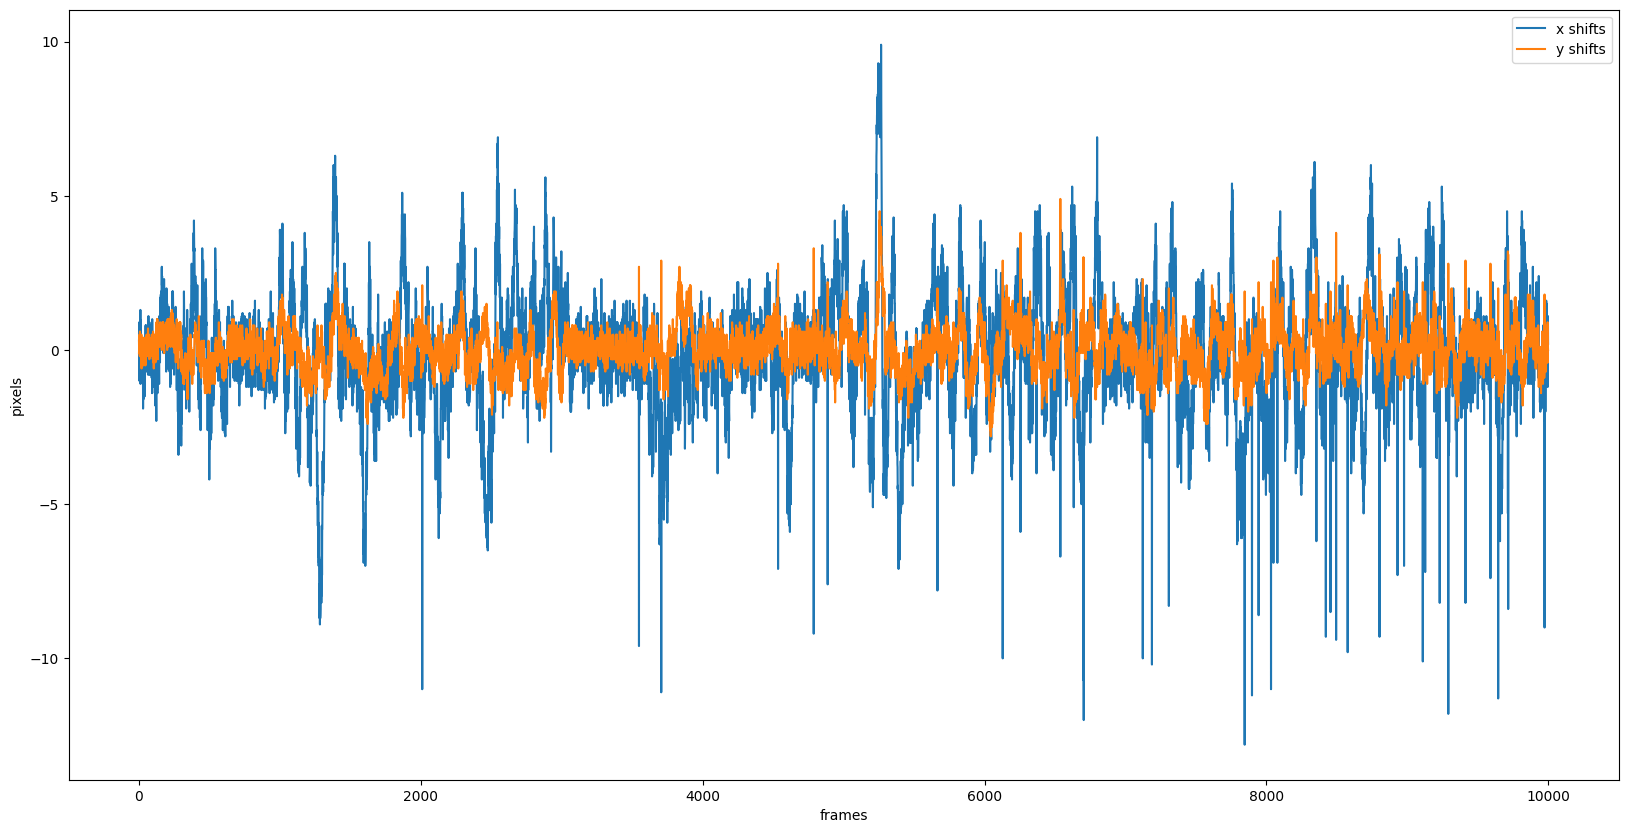

In [10]:
import matplotlib.pyplot as plt

plt.close()
plt.figure(figsize = (20,10))
plt.plot(mc.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')

In [11]:
coordinates = mc.shifts_rig

x_array = [coord[0] for coord in coordinates]
y_array = [coord[1] for coord in coordinates]


import h5py
import numpy as np

# Open the HDF5 file
with h5py.File('/data/iGluSnFR-testing-Sim-Data/SIMULATIONS/Standard2/SIMULATION_scan_00003_Standard2_Trial3_groundtruth.h5', 'r') as file:
    # Read the datasets
    gt_motionC = file['GT/motionC'][:]
    adata_motionC = y_array 

    gt_motionR = file['GT/motionR'][:]
    adata_motionR = x_array

    # Ensure the datasets have the same shape
    # if gt_motionC.shape != adata_motionC.shape:
    #     raise ValueError("Datasets have different shapes and cannot be compared.")
    # if gt_motionR.shape != adata_motionR.shape:
    #     raise ValueError("Datasets have different shapes and cannot be compared.")

    # Compute the mean of each signal
    mean_gt_motionC = np.mean(gt_motionC)
    mean_motionC = np.mean(y_array)
    mean_gt_motionR = np.mean(gt_motionR)
    mean_motionR = np.mean(x_array)

    # Center the signals by subtracting the mean
    centered_gt_motionC = gt_motionC - mean_gt_motionC
    centered_motionC = adata_motionC - mean_motionC
    centered_gt_motionR = gt_motionR - mean_gt_motionR
    centered_motionR = adata_motionR - mean_motionR

    # Compute the Mean Squared Error (MSE)
    mse_c = np.mean(np.square(centered_gt_motionC - centered_motionC))
    mse_r = np.mean(np.square(centered_gt_motionR - centered_motionR))

    print(f"Mean Squared Error (MSE) between centered GT/motionC and aData/motionC: {mse_c}")
    print(f"Mean Squared Error (MSE) between centered GT/motionR and aData/motionR: {mse_r}")

Mean Squared Error (MSE) between centered GT/motionC and aData/motionC: 1.7882964160704025
Mean Squared Error (MSE) between centered GT/motionR and aData/motionR: 14.08432058607022


In [6]:
#%% inspect movie
downsample_ratio = .2
m_rig = cm.load(mc.mmap_file)
# bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(int)
# m_rig.resize(1, 1, downsample_ratio).play(
#     q_max=99.5, fr=30, magnification=2, bord_px = 0*bord_px_rig) # press q to exit

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


In [10]:
m_rig.save('caiman.tif')

'/root/caiman_data/temp/caiman.tif'

# Scratch

In [1]:
import os

tif_files = []

data_dir = '/root/capsule/data/iGluSnFR-testing-Sim-Data_2'
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.tif'):
            tif_files.append(os.path.join(root, file))



In [2]:
tif_files

['/root/capsule/data/iGluSnFR-testing-Sim-Data_2/8/SIMULATION_scan_00003_8_Trial2.tif',
 '/root/capsule/data/iGluSnFR-testing-Sim-Data_2/8/SIMULATION_scan_00003_8_Trial4.tif',
 '/root/capsule/data/iGluSnFR-testing-Sim-Data_2/8/SIMULATION_scan_00003_8_Trial3.tif',
 '/root/capsule/data/iGluSnFR-testing-Sim-Data_2/8/SIMULATION_scan_00003_8_Trial5.tif',
 '/root/capsule/data/iGluSnFR-testing-Sim-Data_2/8/SIMULATION_scan_00003_8_Trial1.tif',
 '/root/capsule/data/iGluSnFR-testing-Sim-Data_2/17/SIMULATION_scan_00003_17_Trial2.tif',
 '/root/capsule/data/iGluSnFR-testing-Sim-Data_2/17/SIMULATION_scan_00003_17_Trial4.tif',
 '/root/capsule/data/iGluSnFR-testing-Sim-Data_2/17/SIMULATION_scan_00003_17_Trial3.tif',
 '/root/capsule/data/iGluSnFR-testing-Sim-Data_2/17/SIMULATION_scan_00003_17_Trial5.tif',
 '/root/capsule/data/iGluSnFR-testing-Sim-Data_2/17/SIMULATION_scan_00003_17_Trial1.tif',
 '/root/capsule/data/iGluSnFR-testing-Sim-Data_2/22/SIMULATION_scan_00003_22_Trial2.tif',
 '/root/capsule/data

In [3]:
import os

data_dir = '/root/capsule/data/iGluSnFR-testing-Sim-Data_2'
tif_files = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.tif'):
            file_path = os.path.join(root, file)
            folder_name = os.path.basename(os.path.dirname(file_path))
            tif_files.append((file_path, folder_name))

for file_path, folder_name in tif_files:
    print(f"File path: {file_path}, Folder name: {folder_name}")

File path: /root/capsule/data/iGluSnFR-testing-Sim-Data_2/8/SIMULATION_scan_00003_8_Trial2.tif, Folder name: 8
File path: /root/capsule/data/iGluSnFR-testing-Sim-Data_2/8/SIMULATION_scan_00003_8_Trial4.tif, Folder name: 8
File path: /root/capsule/data/iGluSnFR-testing-Sim-Data_2/8/SIMULATION_scan_00003_8_Trial3.tif, Folder name: 8
File path: /root/capsule/data/iGluSnFR-testing-Sim-Data_2/8/SIMULATION_scan_00003_8_Trial5.tif, Folder name: 8
File path: /root/capsule/data/iGluSnFR-testing-Sim-Data_2/8/SIMULATION_scan_00003_8_Trial1.tif, Folder name: 8
File path: /root/capsule/data/iGluSnFR-testing-Sim-Data_2/17/SIMULATION_scan_00003_17_Trial2.tif, Folder name: 17
File path: /root/capsule/data/iGluSnFR-testing-Sim-Data_2/17/SIMULATION_scan_00003_17_Trial4.tif, Folder name: 17
File path: /root/capsule/data/iGluSnFR-testing-Sim-Data_2/17/SIMULATION_scan_00003_17_Trial3.tif, Folder name: 17
File path: /root/capsule/data/iGluSnFR-testing-Sim-Data_2/17/SIMULATION_scan_00003_17_Trial5.tif, Folde

In [5]:
name, ext = os.path.splitext(os.path.basename(file_path))

('SIMULATION_scan_00003_16_Trial2', '.tif')

In [5]:
A = ScanImageTiffReader('../data/iGluSnFR-testing-Sim-Data_2/17/SIMULATION_scan_00003_17_Trial4.tif')
Ad = np.array(A.data(), dtype=np.float32)

# Plot results

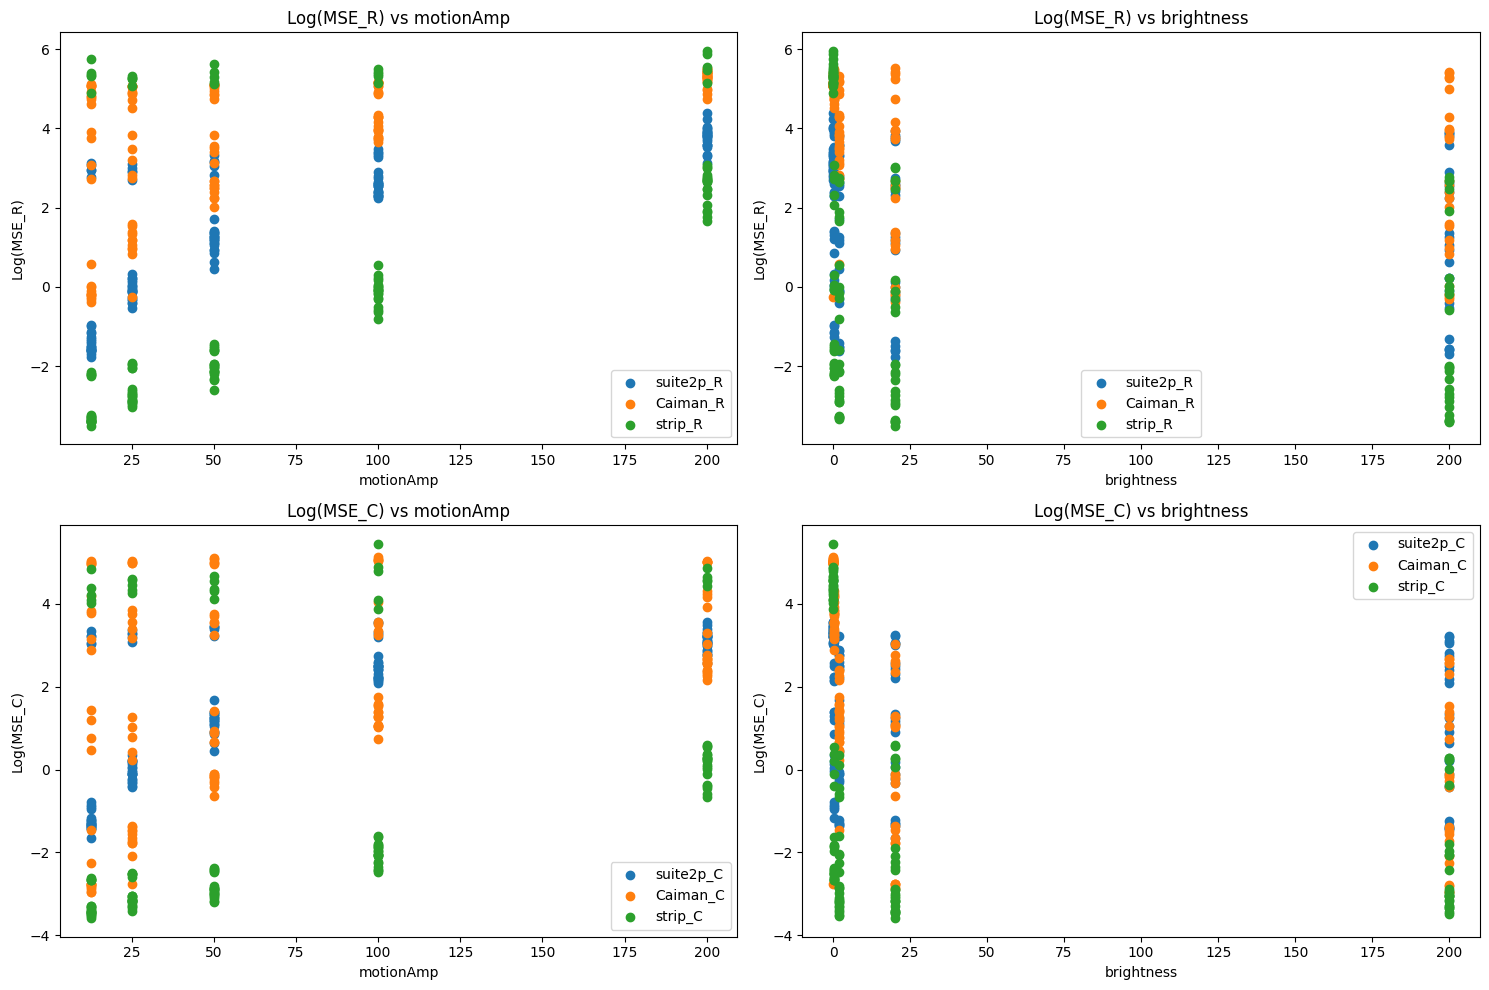

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
parameters = pd.read_csv('/root/capsule/scratch/parameters.csv')
registration_results = pd.read_csv('/root/capsule/scratch/registration_results.csv')

# Extract SimDescription from file_name in registration_results
registration_results['SimDescription'] = registration_results['file_name'].apply(lambda x: int(x.split('_')[3]))

# Merge the data on SimDescription
merged_data = pd.merge(registration_results, parameters, on='SimDescription')

# Define the MSE columns
mse_columns_R = ['suite2p_R', 'Caiman_R', 'strip_R']
mse_columns_C = ['suite2p_C', 'Caiman_C', 'strip_C']

# Take the logarithm of the MSE values
for col in mse_columns_R + mse_columns_C:
    merged_data[col] = np.log(merged_data[col])

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Log(MSE_R) vs motionAmp
for col in mse_columns_R:
    axes[0, 0].scatter(merged_data['motionAmp'], merged_data[col], label=col)
axes[0, 0].set_title('Log(MSE_R) vs motionAmp')
axes[0, 0].set_xlabel('motionAmp')
axes[0, 0].set_ylabel('Log(MSE_R)')
axes[0, 0].legend()

# Plot 2: Log(MSE_R) vs brightness
for col in mse_columns_R:
    axes[0, 1].scatter(merged_data['brightness'], merged_data[col], label=col)
axes[0, 1].set_title('Log(MSE_R) vs brightness')
axes[0, 1].set_xlabel('brightness')
axes[0, 1].set_ylabel('Log(MSE_R)')
axes[0, 1].legend()

# Plot 3: Log(MSE_C) vs motionAmp
for col in mse_columns_C:
    axes[1, 0].scatter(merged_data['motionAmp'], merged_data[col], label=col)
axes[1, 0].set_title('Log(MSE_C) vs motionAmp')
axes[1, 0].set_xlabel('motionAmp')
axes[1, 0].set_ylabel('Log(MSE_C)')
axes[1, 0].legend()

# Plot 4: Log(MSE_C) vs brightness
for col in mse_columns_C:
    axes[1, 1].scatter(merged_data['brightness'], merged_data[col], label=col)
axes[1, 1].set_title('Log(MSE_C) vs brightness')
axes[1, 1].set_xlabel('brightness')
axes[1, 1].set_ylabel('Log(MSE_C)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

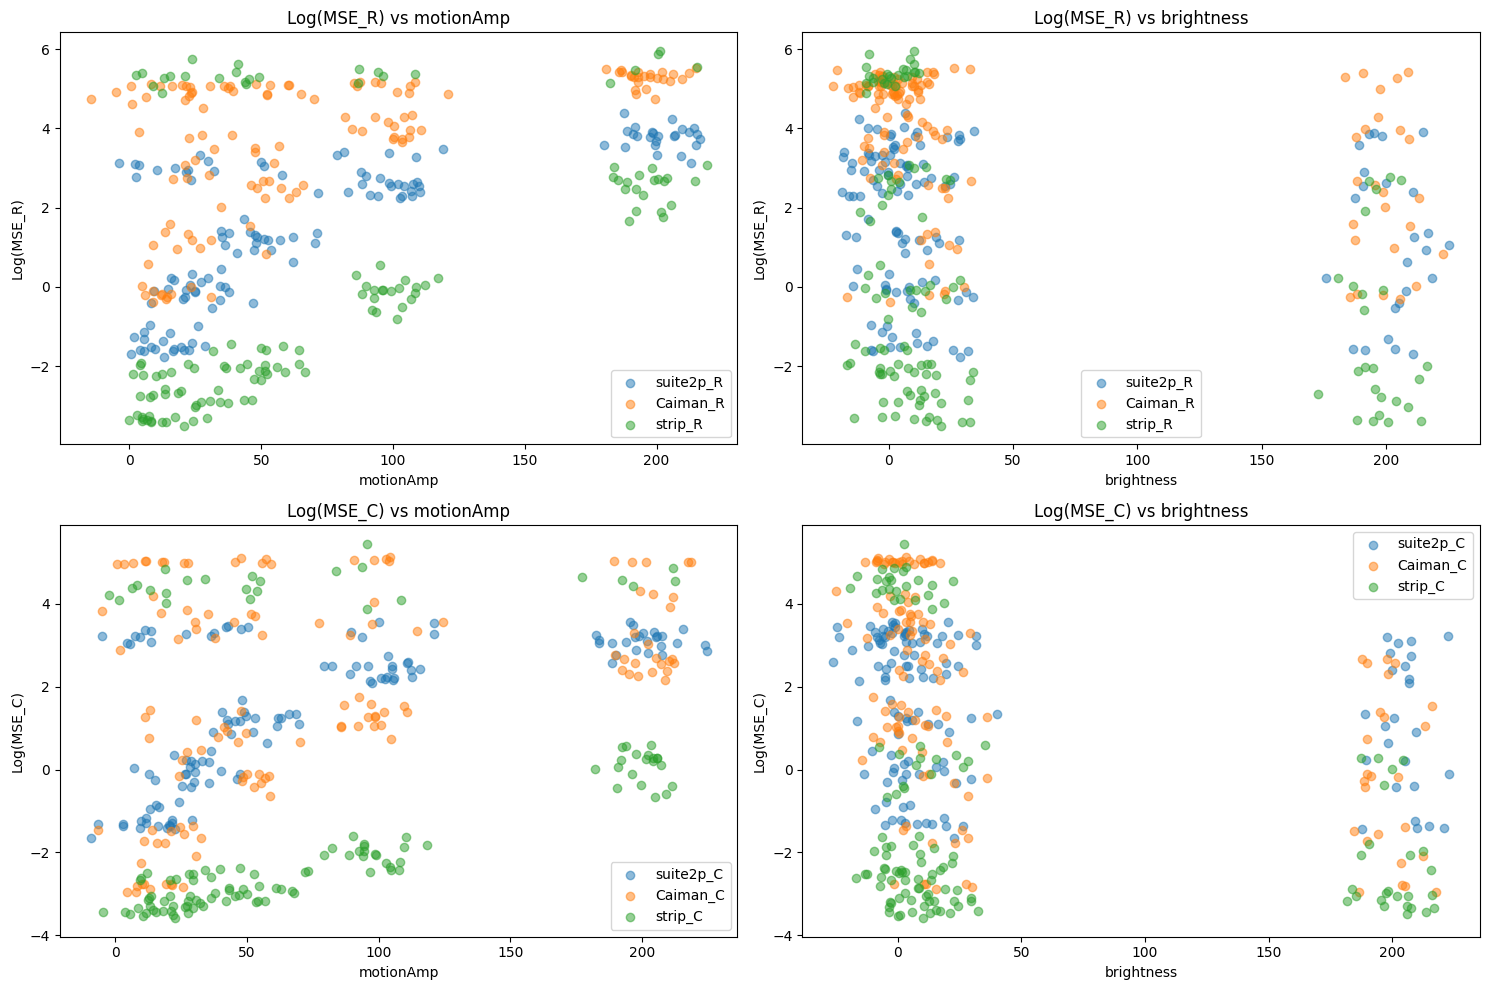

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
parameters = pd.read_csv('/root/capsule/scratch/parameters.csv')
registration_results = pd.read_csv('/root/capsule/scratch/registration_results.csv')

# Extract SimDescription from file_name in registration_results
registration_results['SimDescription'] = registration_results['file_name'].apply(lambda x: int(x.split('_')[3]))

# Merge the data on SimDescription
merged_data = pd.merge(registration_results, parameters, on='SimDescription')

# Define the MSE columns
mse_columns_R = ['suite2p_R', 'Caiman_R', 'strip_R']
mse_columns_C = ['suite2p_C', 'Caiman_C', 'strip_C']

# Take the logarithm of the MSE values
for col in mse_columns_R + mse_columns_C:
    merged_data[col] = np.log(merged_data[col])

# Function to add jitter
def add_jitter(arr, jitter_amount=10):
    return arr + np.random.normal(0, jitter_amount, arr.shape)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Log(MSE_R) vs motionAmp with jitter and transparency
for col in mse_columns_R:
    axes[0, 0].scatter(add_jitter(merged_data['motionAmp']), merged_data[col], label=col, alpha=0.5)
axes[0, 0].set_title('Log(MSE_R) vs motionAmp')
axes[0, 0].set_xlabel('motionAmp')
axes[0, 0].set_ylabel('Log(MSE_R)')
axes[0, 0].legend()
# axes[0, 0].set_xlim(merged_data['motionAmp'].min(), merged_data['motionAmp'].max())

# Plot 2: Log(MSE_R) vs brightness with jitter and transparency
for col in mse_columns_R:
    axes[0, 1].scatter(add_jitter(merged_data['brightness']), merged_data[col], label=col, alpha=0.5)
axes[0, 1].set_title('Log(MSE_R) vs brightness')
axes[0, 1].set_xlabel('brightness')
axes[0, 1].set_ylabel('Log(MSE_R)')
axes[0, 1].legend()
# axes[0, 1].set_xlim(merged_data['brightness'].min(), merged_data['brightness'].max())

# Plot 3: Log(MSE_C) vs motionAmp with jitter and transparency
for col in mse_columns_C:
    axes[1, 0].scatter(add_jitter(merged_data['motionAmp']), merged_data[col], label=col, alpha=0.5)
axes[1, 0].set_title('Log(MSE_C) vs motionAmp')
axes[1, 0].set_xlabel('motionAmp')
axes[1, 0].set_ylabel('Log(MSE_C)')
axes[1, 0].legend()
# axes[1, 0].set_xlim(merged_data['motionAmp'].min(), merged_data['motionAmp'].max())

# Plot 4: Log(MSE_C) vs brightness with jitter and transparency
for col in mse_columns_C:
    axes[1, 1].scatter(add_jitter(merged_data['brightness']), merged_data[col], label=col, alpha=0.5)
axes[1, 1].set_title('Log(MSE_C) vs brightness')
axes[1, 1].set_xlabel('brightness')
axes[1, 1].set_ylabel('Log(MSE_C)')
axes[1, 1].legend()
# axes[1, 1].set_xlim(merged_data['brightness'].min(), merged_data['brightness'].max())

plt.tight_layout()
plt.show()


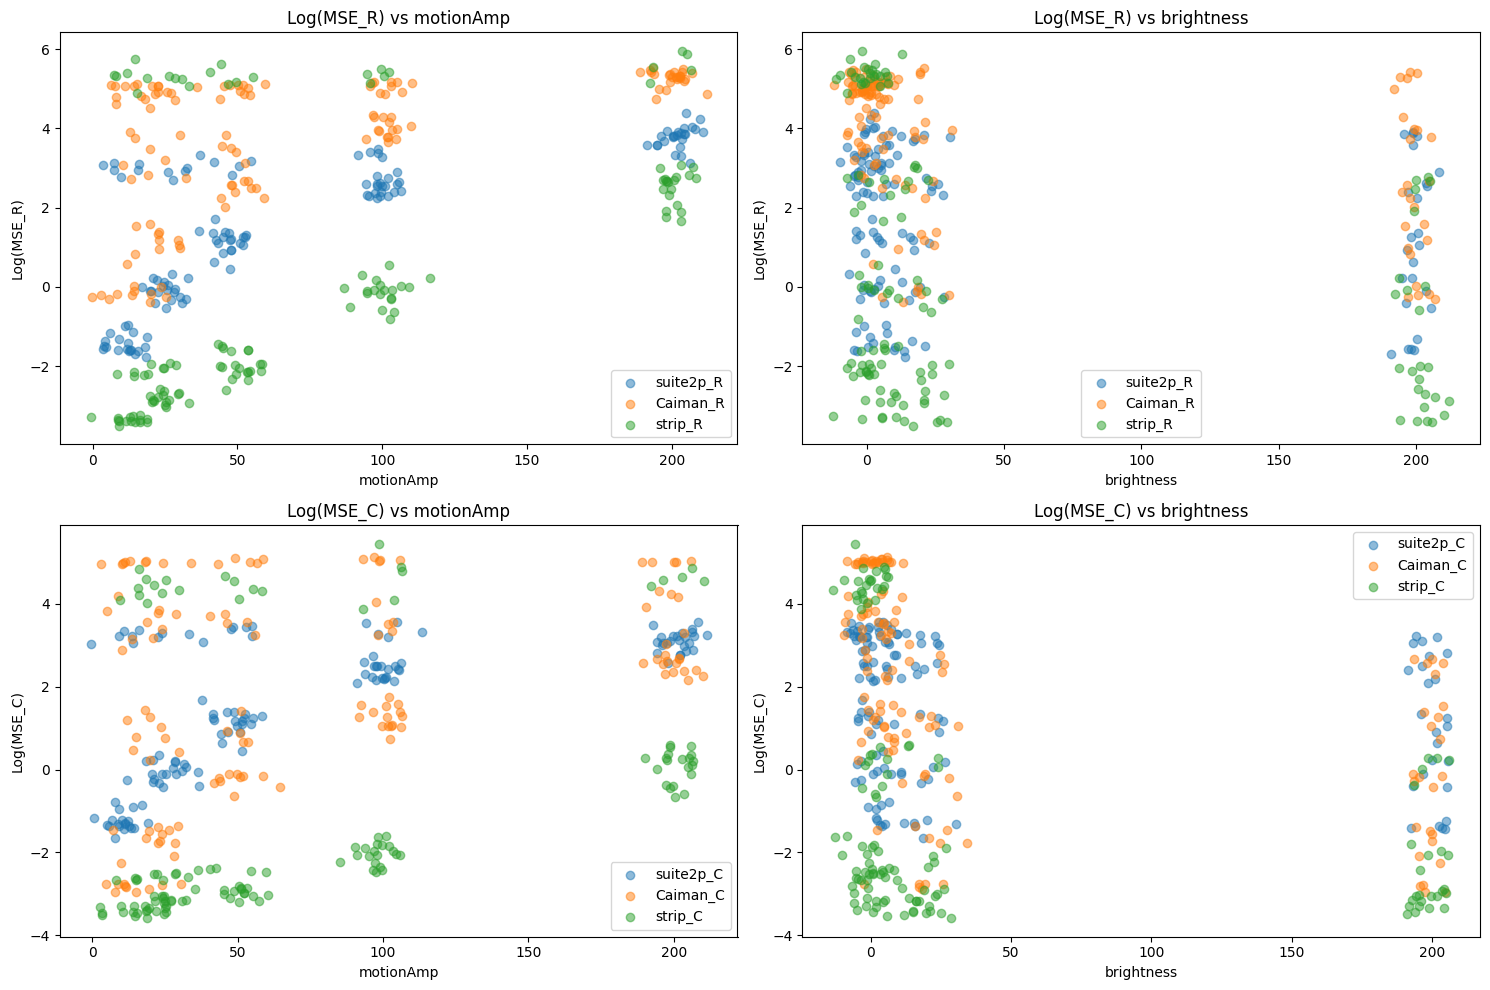

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
parameters = pd.read_csv('/root/capsule/scratch/parameters.csv')
registration_results = pd.read_csv('/root/capsule/scratch/registration_results.csv')

# Extract SimDescription from file_name in registration_results
registration_results['SimDescription'] = registration_results['file_name'].apply(lambda x: int(x.split('_')[3]))

# Merge the data on SimDescription
merged_data = pd.merge(registration_results, parameters, on='SimDescription')

# Define the MSE columns
mse_columns_R = ['suite2p_R', 'Caiman_R', 'strip_R']
mse_columns_C = ['suite2p_C', 'Caiman_C', 'strip_C']

# Take the logarithm of the MSE values
for col in mse_columns_R + mse_columns_C:
    merged_data[col] = np.log(merged_data[col])

# Function to add jitter
def add_jitter(arr, jitter_amount=5):
    return arr + np.random.normal(0, jitter_amount, arr.shape)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Log(MSE_R) vs motionAmp with jitter and transparency
for col in mse_columns_R:
    axes[0, 0].scatter(add_jitter(merged_data['motionAmp']), merged_data[col], label=col, alpha=0.5)
axes[0, 0].set_title('Log(MSE_R) vs motionAmp')
axes[0, 0].set_xlabel('motionAmp')
axes[0, 0].set_ylabel('Log(MSE_R)')
axes[0, 0].legend()

# Plot 2: Log(MSE_R) vs brightness with jitter and transparency
for col in mse_columns_R:
    axes[0, 1].scatter(add_jitter(merged_data['brightness']), merged_data[col], label=col, alpha=0.5)
axes[0, 1].set_title('Log(MSE_R) vs brightness')
axes[0, 1].set_xlabel('brightness')
axes[0, 1].set_ylabel('Log(MSE_R)')
axes[0, 1].legend()

# Plot 3: Log(MSE_C) vs motionAmp with jitter and transparency
for col in mse_columns_C:
    axes[1, 0].scatter(add_jitter(merged_data['motionAmp']), merged_data[col], label=col, alpha=0.5)
axes[1, 0].set_title('Log(MSE_C) vs motionAmp')
axes[1, 0].set_xlabel('motionAmp')
axes[1, 0].set_ylabel('Log(MSE_C)')
axes[1, 0].legend()

# Plot 4: Log(MSE_C) vs brightness with jitter and transparency
for col in mse_columns_C:
    axes[1, 1].scatter(add_jitter(merged_data['brightness']), merged_data[col], label=col, alpha=0.5)
axes[1, 1].set_title('Log(MSE_C) vs brightness')
axes[1, 1].set_xlabel('brightness')
axes[1, 1].set_ylabel('Log(MSE_C)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


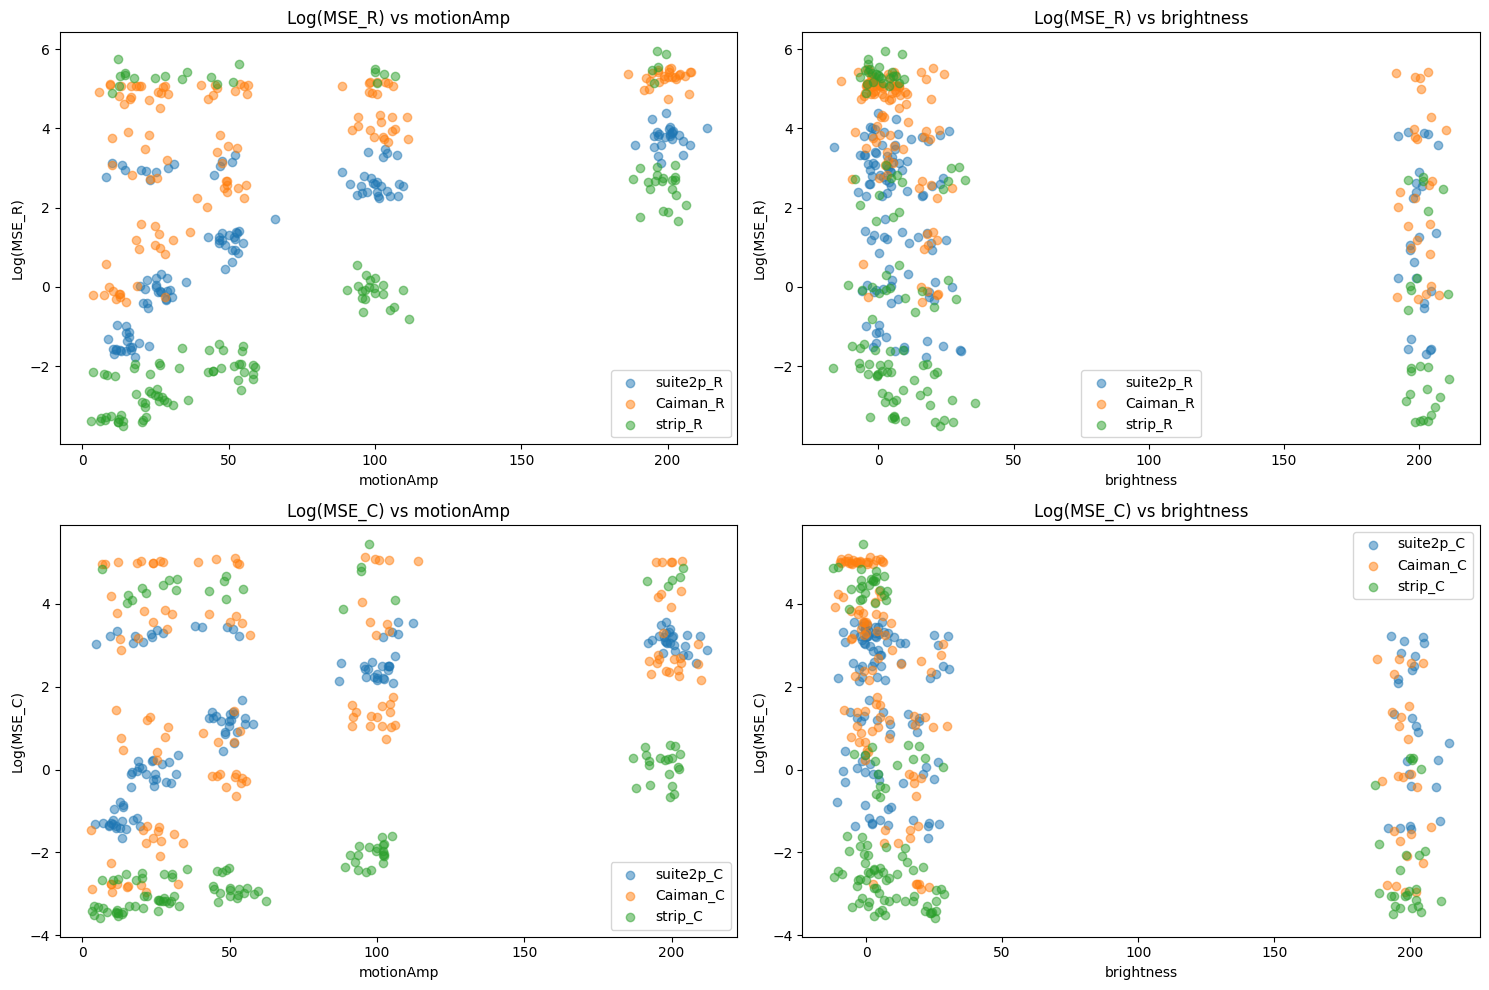

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
parameters = pd.read_csv('/root/capsule/scratch/parameters.csv')
registration_results = pd.read_csv('/root/capsule/scratch/registration_results.csv')

# Extract SimDescription from file_name in registration_results
registration_results['SimDescription'] = registration_results['file_name'].apply(lambda x: int(x.split('_')[3]))

# Merge the data on SimDescription
merged_data = pd.merge(registration_results, parameters, on='SimDescription')

# Define the MSE columns
mse_columns_R = ['suite2p_R', 'Caiman_R', 'strip_R']
mse_columns_C = ['suite2p_C', 'Caiman_C', 'strip_C']

# Take the logarithm of the MSE values separately
for col in mse_columns_R:
    merged_data_[col] = np.log(merged_data[col])

for col in mse_columns_C:
    merged_data[col] = np.log(merged_data[col])

# Function to add jitter
def add_jitter(arr, jitter_amount=5):
    return arr + np.random.normal(0, jitter_amount, arr.shape)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Log(MSE_R) vs motionAmp with jitter and transparency
for col in mse_columns_R:
    axes[0, 0].scatter(add_jitter(merged_data['motionAmp']), merged_data[col], label=col, alpha=0.5)
axes[0, 0].set_title('Log(MSE_R) vs motionAmp')
axes[0, 0].set_xlabel('motionAmp')
axes[0, 0].set_ylabel('Log(MSE_R)')
axes[0, 0].legend()

# Plot 2: Log(MSE_R) vs brightness with jitter and transparency
for col in mse_columns_R:
    axes[0, 1].scatter(add_jitter(merged_data['brightness']), merged_data[col], label=col, alpha=0.5)
axes[0, 1].set_title('Log(MSE_R) vs brightness')
axes[0, 1].set_xlabel('brightness')
axes[0, 1].set_ylabel('Log(MSE_R)')
axes[0, 1].legend()

# Plot 3: Log(MSE_C) vs motionAmp with jitter and transparency
for col in mse_columns_C:
    axes[1, 0].scatter(add_jitter(merged_data['motionAmp']), merged_data[col], label=col, alpha=0.5)
axes[1, 0].set_title('Log(MSE_C) vs motionAmp')
axes[1, 0].set_xlabel('motionAmp')
axes[1, 0].set_ylabel('Log(MSE_C)')
axes[1, 0].legend()

# Plot 4: Log(MSE_C) vs brightness with jitter and transparency
for col in mse_columns_C:
    axes[1, 1].scatter(add_jitter(merged_data['brightness']), merged_data[col], label=col, alpha=0.5)
axes[1, 1].set_title('Log(MSE_C) vs brightness')
axes[1, 1].set_xlabel('brightness')
axes[1, 1].set_ylabel('Log(MSE_C)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


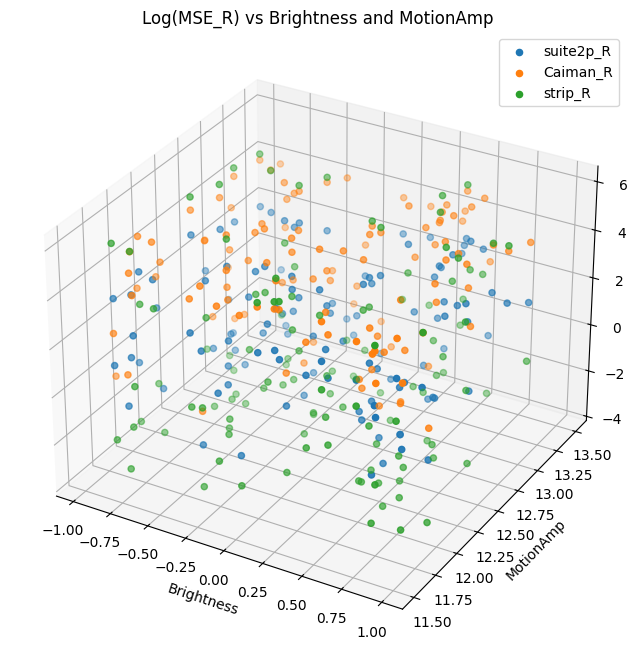

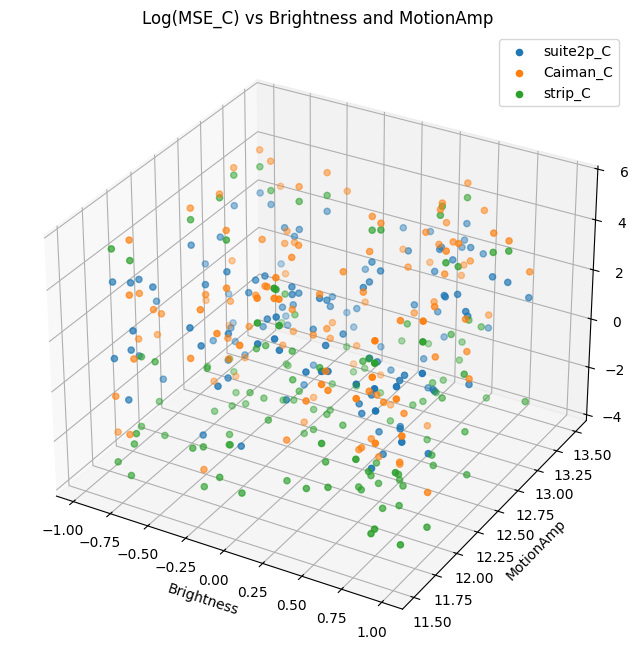

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the data
parameters_df = pd.read_csv('/root/capsule/scratch/parameters.csv')
registration_results_df = pd.read_csv('/root/capsule/scratch/registration_results.csv')

# Extract SimDescription from file_name in registration_results_df
registration_results_df['SimDescription'] = registration_results_df['file_name'].apply(lambda x: int(x.split('_')[2]))

# Merge the dataframes on SimDescription
merged_df = pd.merge(registration_results_df, parameters_df, on='SimDescription')

# List of MSE columns
mse_columns_R = ['suite2p_R', 'Caiman_R', 'strip_R']
mse_columns_C = ['suite2p_C', 'Caiman_C', 'strip_C']

# Apply log transformation
for col in mse_columns_R + mse_columns_C:
    merged_df[f'log_{col}'] = np.log(merged_df[col])

# Add jitter to avoid overlapping points
def add_jitter(arr, jitter_strength=1):
    return arr + np.random.uniform(-jitter_strength, jitter_strength, arr.shape)

merged_df['motionAmp_jitter'] = add_jitter(merged_df['motionAmp'])
merged_df['brightness_jitter'] = add_jitter(merged_df['brightness'])

# Plotting function for R values
def plot_3d_mse_R(df):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    for col in mse_columns_R:
        ax.scatter(df['brightness_jitter'], df['motionAmp_jitter'], df[f'log_{col}'], label=col)
    ax.set_title('Log(MSE_R) vs Brightness and MotionAmp')
    ax.set_xlabel('Brightness')
    ax.set_ylabel('MotionAmp')
    ax.set_zlabel('Log(MSE_R)')
    ax.legend()
    plt.show()

# Plotting function for C values
def plot_3d_mse_C(df):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    for col in mse_columns_C:
        ax.scatter(df['brightness_jitter'], df['motionAmp_jitter'], df[f'log_{col}'], label=col)
    ax.set_title('Log(MSE_C) vs Brightness and MotionAmp')
    ax.set_xlabel('Brightness')
    ax.set_ylabel('MotionAmp')
    ax.set_zlabel('Log(MSE_C)')
    ax.legend()
    plt.show()

# Plot for MSE_R columns
plot_3d_mse_R(merged_df)

# Plot for MSE_C columns
plot_3d_mse_C(merged_df)


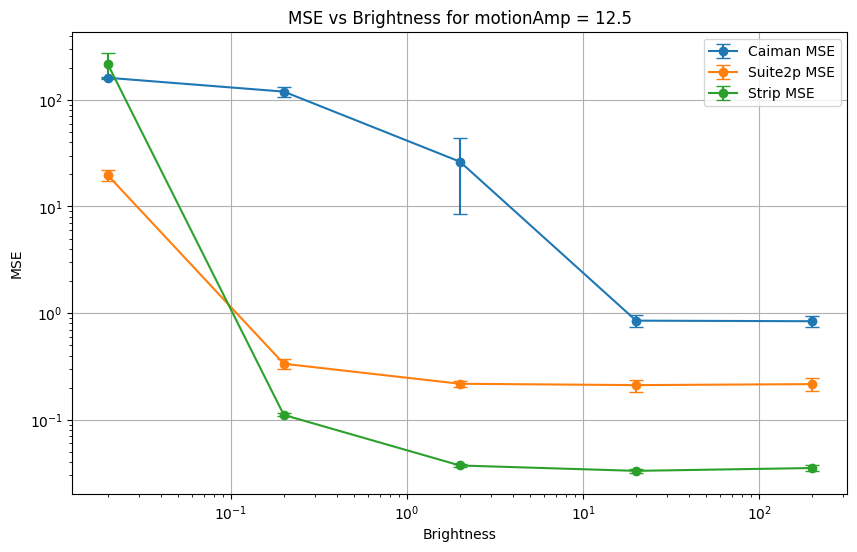

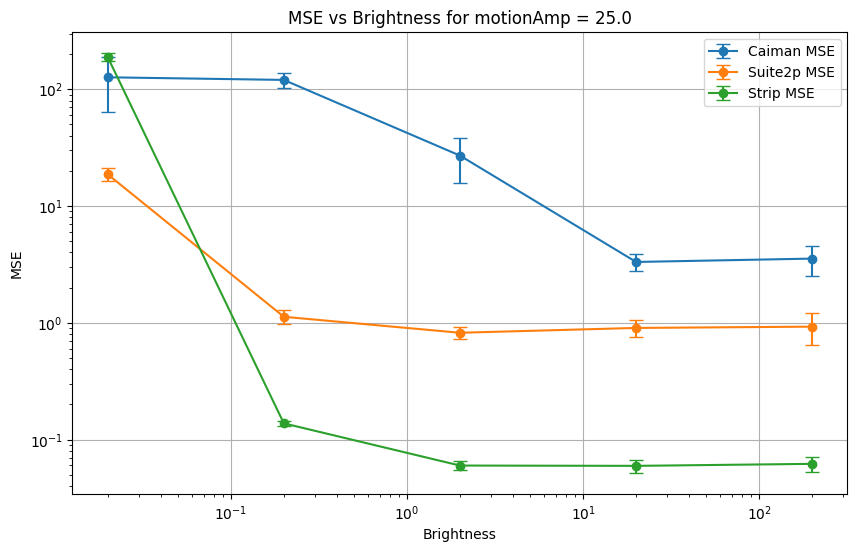

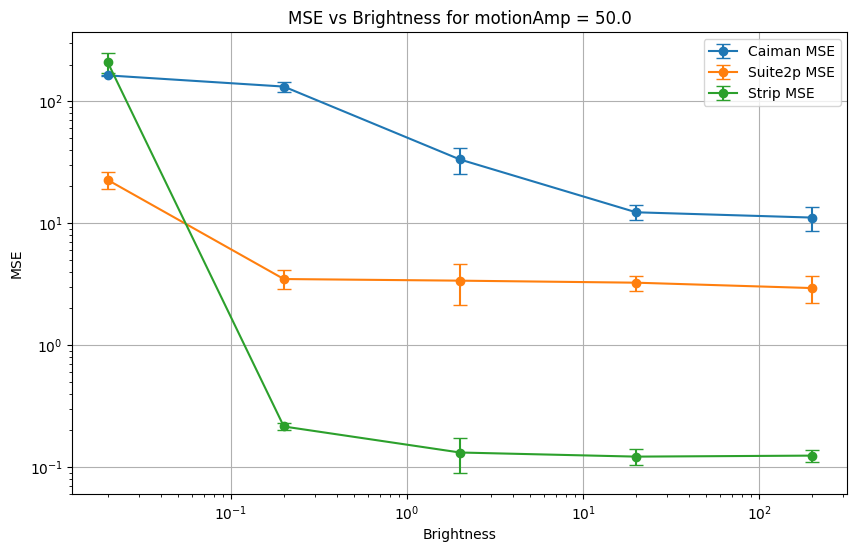

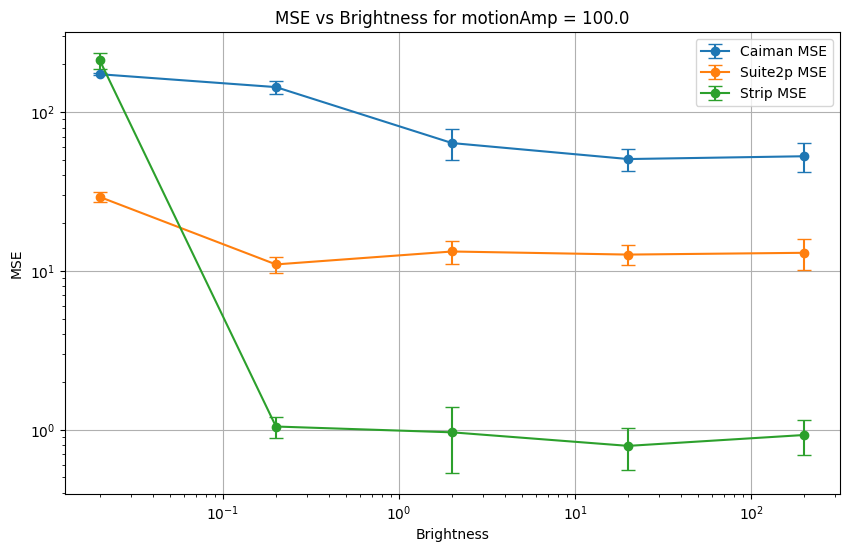

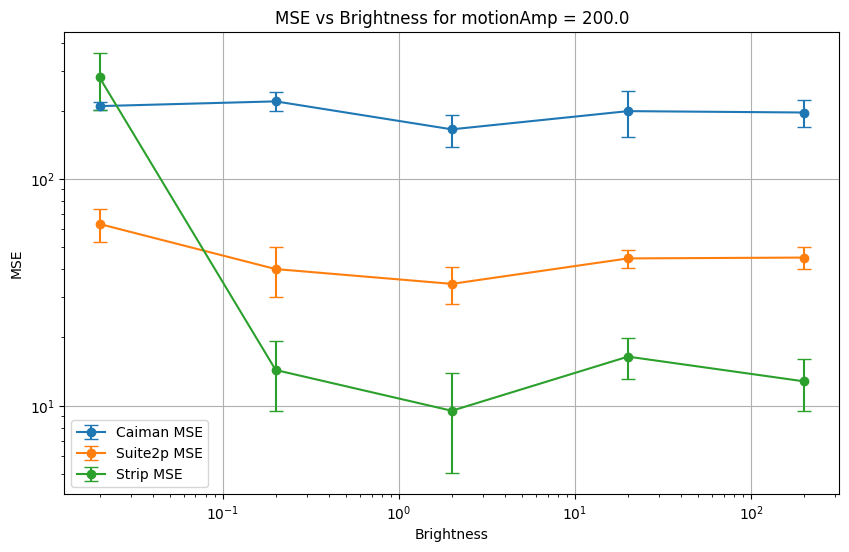

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the data
parameters =  pd.read_csv('/root/capsule/scratch/parameters.csv')
registration_results = pd.read_csv('/root/capsule/scratch/registration_results.csv')

for mA in np.unique(parameters['motionAmp']):
    # Filter parameters for motionAmp = 12.5
    filtered_params = parameters[parameters['motionAmp'] == mA]

    # Extract SimDescription and brightness
    sim_descriptions = filtered_params['SimDescription'].tolist()
    brightness_values = filtered_params['brightness'].tolist()

    # Initialize dictionaries to store MSE values grouped by brightness
    caiman_mse_dict = defaultdict(list)
    suite2p_mse_dict = defaultdict(list)
    strip_mse_dict = defaultdict(list)

    # Extract MSE values for the corresponding SimDescriptions
    for sim_desc, brightness in zip(sim_descriptions, brightness_values):
        for trial in range(1, 6):
            filename = f'SIMULATION_scan_00003_{sim_desc}_Trial{trial}.tif'
            row = registration_results[registration_results['file_name'] == filename]
            if not row.empty:
                caiman_mse_dict[brightness].append(row['Caiman_R'].values[0])
                suite2p_mse_dict[brightness].append(row['suite2p_R'].values[0])
                strip_mse_dict[brightness].append(row['strip_R'].values[0])

    # Calculate average MSE for each brightness level
    # Calculate average and standard deviation of MSE for each brightness level
    brightness_levels = sorted(caiman_mse_dict.keys())
    caiman_mse_avg = [np.mean(caiman_mse_dict[brightness]) for brightness in brightness_levels]
    caiman_mse_std = [np.std(caiman_mse_dict[brightness]) for brightness in brightness_levels]
    suite2p_mse_avg = [np.mean(suite2p_mse_dict[brightness]) for brightness in brightness_levels]
    suite2p_mse_std = [np.std(suite2p_mse_dict[brightness]) for brightness in brightness_levels]
    strip_mse_avg = [np.mean(strip_mse_dict[brightness]) for brightness in brightness_levels]
    strip_mse_std = [np.std(strip_mse_dict[brightness]) for brightness in brightness_levels]

    # Plot the data
    # Plot the data with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(brightness_levels, caiman_mse_avg, yerr=caiman_mse_std, label='Caiman MSE', marker='o', capsize=5)
    plt.errorbar(brightness_levels, suite2p_mse_avg, yerr=suite2p_mse_std, label='Suite2p MSE', marker='o', capsize=5)
    plt.errorbar(brightness_levels, strip_mse_avg, yerr=strip_mse_std, label='Strip MSE', marker='o', capsize=5)
    plt.xlabel('Brightness')
    plt.ylabel('MSE')
    plt.title(f'MSE vs Brightness for motionAmp = {mA}')
    plt.legend()
    plt.grid(True)

    # Set x-axis to logarithmic scale
    plt.xscale('log')
    plt.yscale('log')

    plt.show()

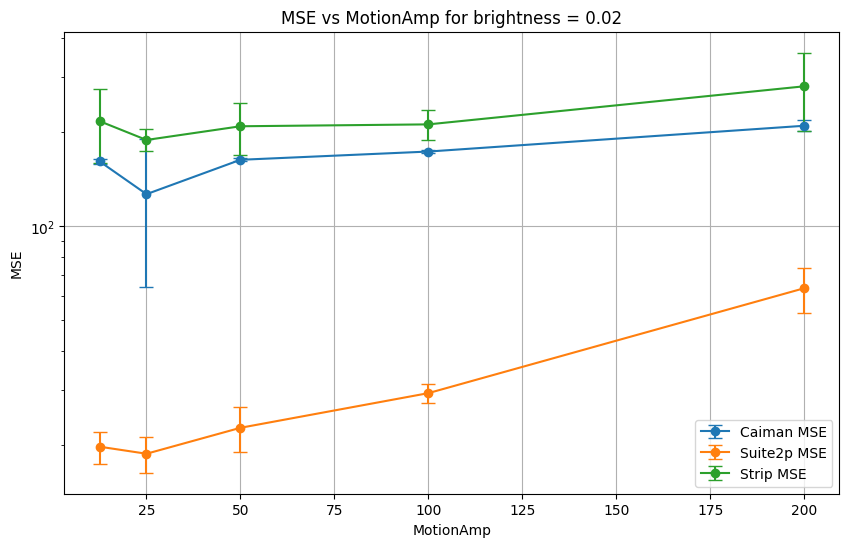

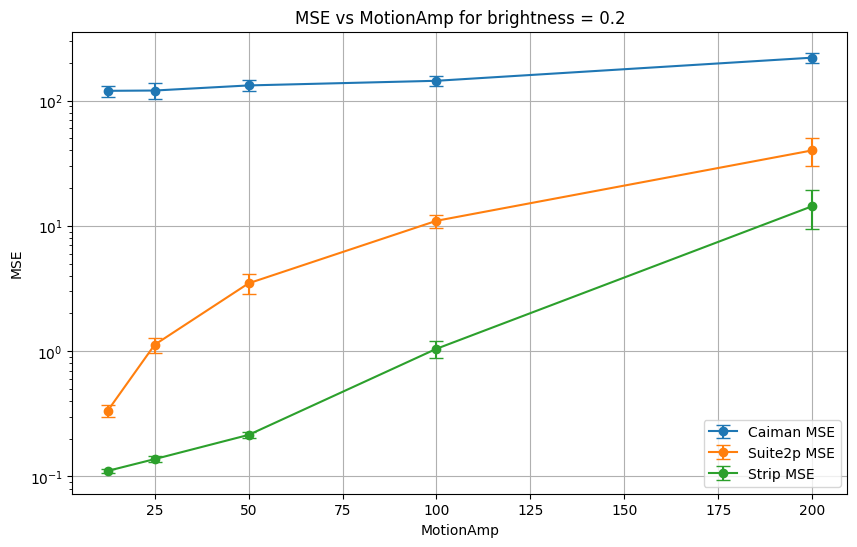

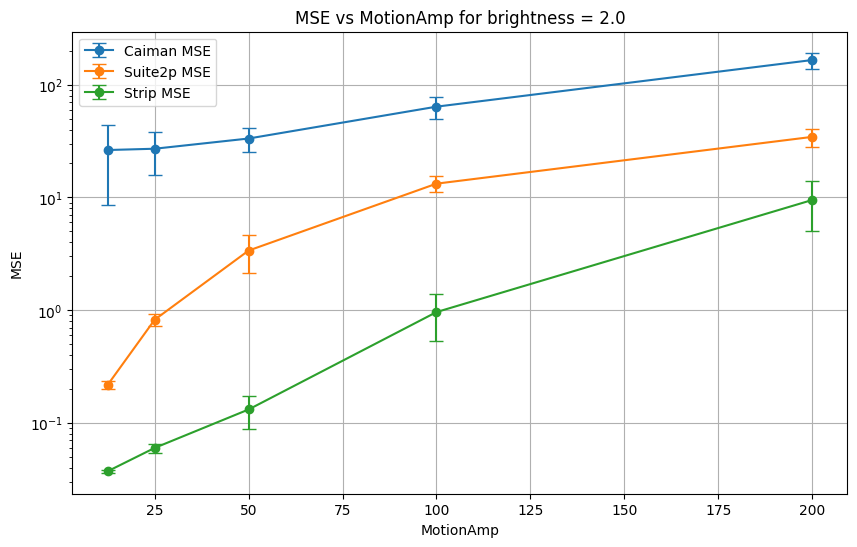

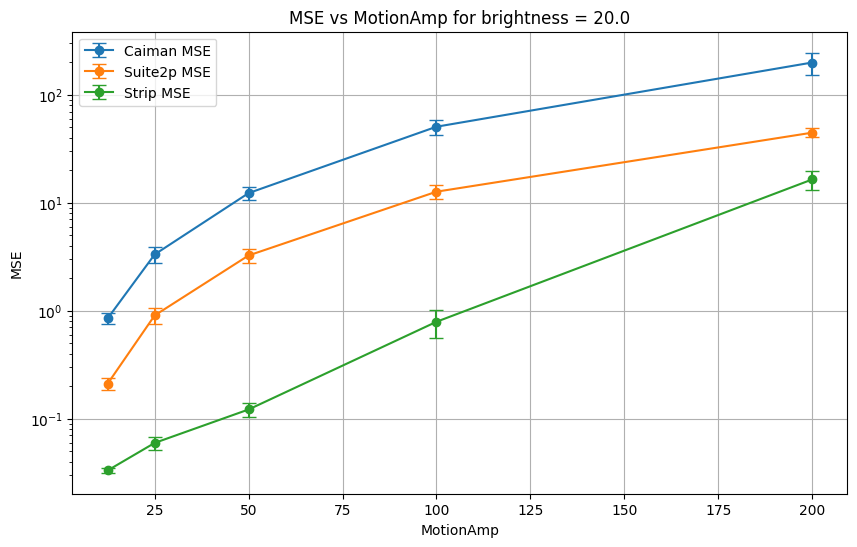

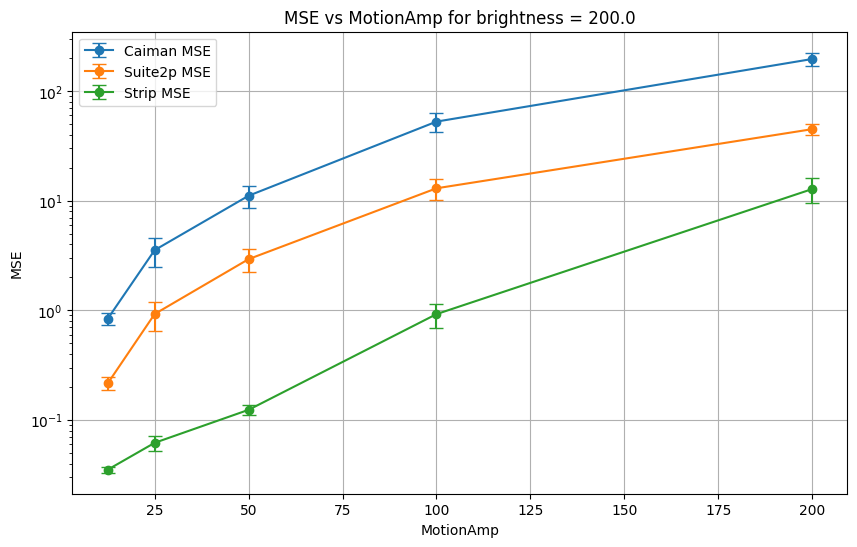

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the data
parameters =  pd.read_csv('/root/capsule/scratch/parameters.csv')
registration_results = pd.read_csv('/root/capsule/scratch/registration_results.csv')

for Br in np.unique(parameters['brightness']):
    # Filter parameters for brightness 
    filtered_params = parameters[parameters['brightness'] == Br]

    # Extract SimDescription and brightness
    sim_descriptions = filtered_params['SimDescription'].tolist()
    motionAmp_values = filtered_params['motionAmp'].tolist()

    # Initialize dictionaries to store MSE values grouped by brightness
    caiman_mse_dict = defaultdict(list)
    suite2p_mse_dict = defaultdict(list)
    strip_mse_dict = defaultdict(list)

    # Extract MSE values for the corresponding SimDescriptions
    for sim_desc, motionAmp in zip(sim_descriptions, motionAmp_values):
        for trial in range(1, 6):
            filename = f'SIMULATION_scan_00003_{sim_desc}_Trial{trial}.tif'
            row = registration_results[registration_results['file_name'] == filename]
            if not row.empty:
                caiman_mse_dict[motionAmp].append(row['Caiman_R'].values[0])
                suite2p_mse_dict[motionAmp].append(row['suite2p_R'].values[0])
                strip_mse_dict[motionAmp].append(row['strip_R'].values[0])

    # Calculate average MSE for each motionAmp level
    # Calculate average and standard deviation of MSE for each brightness level
    motionAmp_levels = sorted(caiman_mse_dict.keys())
    caiman_mse_avg = [np.mean(caiman_mse_dict[motionAmp]) for motionAmp in motionAmp_levels]
    caiman_mse_std = [np.std(caiman_mse_dict[motionAmp]) for motionAmp in motionAmp_levels]
    suite2p_mse_avg = [np.mean(suite2p_mse_dict[motionAmp]) for motionAmp in motionAmp_levels]
    suite2p_mse_std = [np.std(suite2p_mse_dict[motionAmp]) for motionAmp in motionAmp_levels]
    strip_mse_avg = [np.mean(strip_mse_dict[motionAmp]) for motionAmp in motionAmp_levels]
    strip_mse_std = [np.std(strip_mse_dict[motionAmp]) for motionAmp in motionAmp_levels]

    # Plot the data
    # Plot the data with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(motionAmp_levels, caiman_mse_avg, yerr=caiman_mse_std, label='Caiman MSE', marker='o', capsize=5)
    plt.errorbar(motionAmp_levels, suite2p_mse_avg, yerr=suite2p_mse_std, label='Suite2p MSE', marker='o', capsize=5)
    plt.errorbar(motionAmp_levels, strip_mse_avg, yerr=strip_mse_std, label='Strip MSE', marker='o', capsize=5)
    plt.xlabel('MotionAmp')
    plt.ylabel('MSE')
    plt.title(f'MSE vs MotionAmp for brightness = {Br}')
    plt.legend()
    plt.grid(True)

    # Set x-axis to logarithmic scale
    # plt.xscale('log')
    plt.yscale('log')

    plt.show()